In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv', parse_dates=True, dayfirst=False)

In [4]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv')
covid_19_df['Date'] = pd.to_datetime(covid_19_df['Date'])
covid_19_df['Country/Region'] = covid_19_df['Country/Region'].replace('Mainland China', 'China')
covid_19_df.tail(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
16696,Turks and Caicos Islands,United Kingdom,21.694,-71.7979,2020-03-27,0,0,0.0
16697,NaN,MS Zaandam,0.000,0.0000,2020-03-27,0,0,0.0


In [5]:
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
growth = ['Confirmed_growth', 'Deaths_growth', 'Recovered_growth', 'Confirmed_growth_mean']
covid_19_df['Active'] = covid_19_df['Confirmed'] - covid_19_df['Deaths'] - covid_19_df['Recovered']
covid_19_df = covid_19_df.sort_values(by=['Date'], ascending=True)
covid_19_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0.0,0.0
161,NaN,Mongolia,46.8625,103.8467,2020-01-22,0,0,0.0,0.0


### Finding Countries with most confirmed cases

In [6]:
last_covid_df = covid_19_df[covid_19_df['Date'] == covid_19_df['Date'].max()].reset_index(drop=True)
last_covid_df = last_covid_df.drop(columns=['Lat', 'Long'])
top_50 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(50)
grouped_Poland = top_50[top_50.index == "Poland"]
top_10 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(10)
top_10_with_Poland  = pd.concat([top_10, grouped_Poland])

In [7]:
def prepare_data(df, country, *lower_bound):
    df = df[df['Country/Region'] == country]
    if (country == 'China') | (country == 'US') | (country == 'Australia') | (country == 'Canada') | (country == 'Denmark') | (country == 'France') | (country == 'United Kingdom'):
        df = df.groupby('Date').sum().reset_index()
    elif df[df['Province/State'] == country].notna().any().any():
        df = df[df['Province/State'] == country]
    df = df.sort_values(by='Date').reset_index(drop=True)

    if lower_bound:
        df = df[df.Confirmed > lower_bound].reset_index(drop=True)
    date_range = df['Date'].sort_values().drop_duplicates().reset_index(drop=True)
    date_range = date_range.dt.strftime('%d-%m')
    return df, date_range

In [8]:
def show_increment(df, label, date_range):
    my_xticks = range(0, len(date_range), 5)
    my_xticks_labels = list(date_range)[0:len(date_range):5]
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax1 = sns.lineplot(data=df[cases], ax=ax)
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel(label)
    plt.show()
    
    print('\nDaily growth for each types of cases\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(23, 5))
    ax1 = sns.barplot(x=date_range.index, y='Confirmed_growth', data=df, ax=ax1, palette=cm.Blues(df.Confirmed_growth/max(df.Confirmed_growth*1.5)+0.3))
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel('Daily Confirmed growth')
    ax1.set_ylabel('Cases')
    
    ax2 = sns.barplot(x=date_range.index, y='Deaths_growth', data=df, ax=ax2, palette=cm.autumn_r(df.Deaths_growth/max(df.Deaths_growth*1.5)+0.3))
    ax2.set_xticks(my_xticks)
    ax2.set_xticklabels(my_xticks_labels)
    ax2.set_xlabel('Daily Deaths growth')
    ax2.set_ylabel('Cases')
    
    ax3 = sns.barplot(x=date_range.index, y='Recovered_growth', data=df, ax=ax3, palette=cm.Greens(df.Recovered_growth/max(df.Recovered_growth)+0.3))
    ax3.set_xticks(my_xticks)
    ax3.set_xticklabels(my_xticks_labels)
    ax3.set_xlabel('Daily Recovered growth')
    ax3.set_ylabel('Cases')
    
    plt.show()

In [9]:
def add_data(covid_19_df):
    covid_19_df['Confirmed_growth'] = covid_19_df['Confirmed'] - covid_19_df['Confirmed'].shift()
    covid_19_df['Confirmed_growth'][0] = covid_19_df['Confirmed'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Deaths_growth'] = covid_19_df['Deaths'] - covid_19_df['Deaths'].shift()
    covid_19_df['Deaths_growth'][0] = covid_19_df['Deaths'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Recovered_growth'] = covid_19_df['Recovered'] - covid_19_df['Recovered'].shift()
    covid_19_df['Recovered_growth'][0] = covid_19_df['Recovered'][0]
    covid_19_df = covid_19_df.fillna(0)
    return covid_19_df

### Plot for 10 countries with most confirmed cases with start data: 50 confirmed cases<br> on one plot

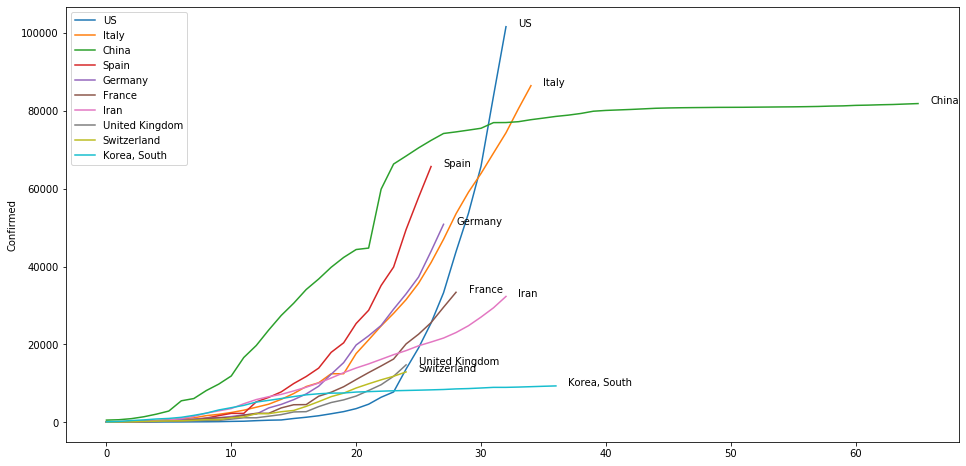

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

for index, country in enumerate(top_10.index):
    df, date_range = prepare_data(covid_19_df, country, 50)
    x=df.index
    y=df.Confirmed    
    ax = sns.lineplot(x=x, y=y, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')

plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without US, China and Italy

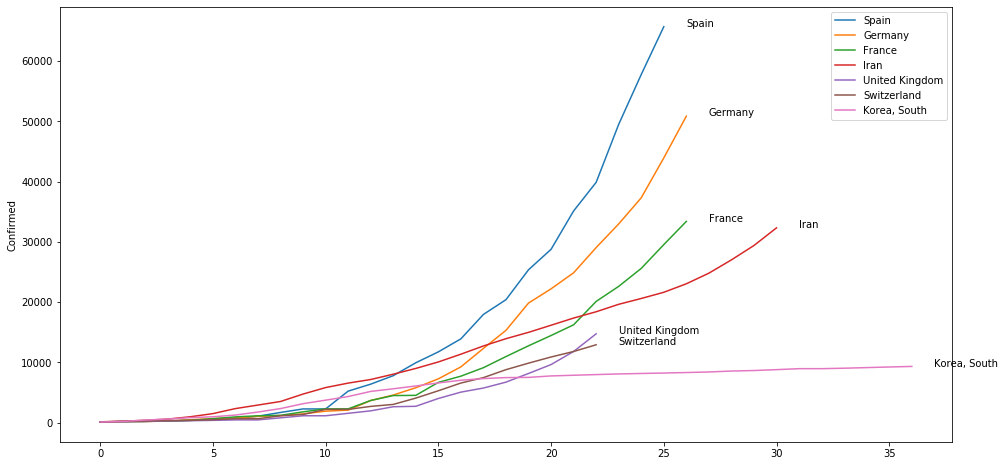

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10.index[3:10]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot with Poland

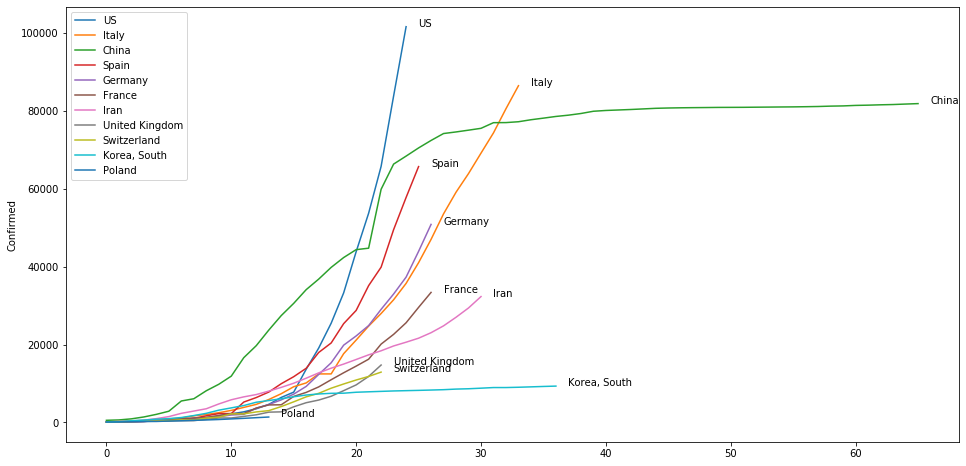

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plot for 10 countries with most confirmed cases with start data: 100 confirmed cases<br> on one plot without China & Italy with Poland

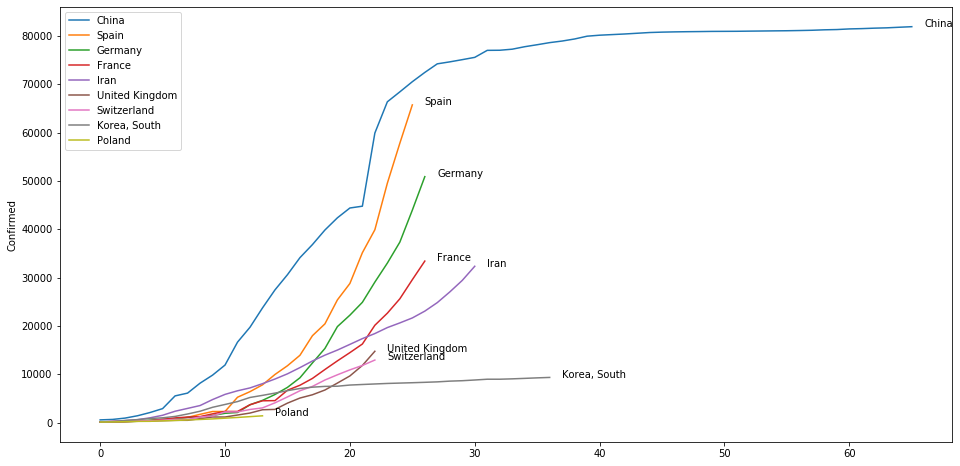

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
for index, country in enumerate(top_10_with_Poland.index[2:]):
    df, date_range = prepare_data(covid_19_df, country, 100)
    x=df.index
    y=df.Confirmed
    ax = sns.lineplot(x=df.index, y=df.Confirmed, data=df, label=country)
    last = len(y)
    ax.text(last, y.iloc[last-1], country, horizontalalignment='left', size='medium', color='black')
    
plt.show()

### Plots for 50 countries with most confirmed cases with start data: 50 confirmed cases

The line plot presents all data in the following days starting from the moment when there were more than 50 confirmed cases.<br>
The bar plots show the daily increase in each category. There are some days with negative values caused by changes in the data tables in the source data - maybe some of the cases were wrongly classified as recovered and therefore were removed. 

1 . US
Confirmed: 101657 
Active: 99207.0 
Recovered: 869.0 
Deaths: 1581


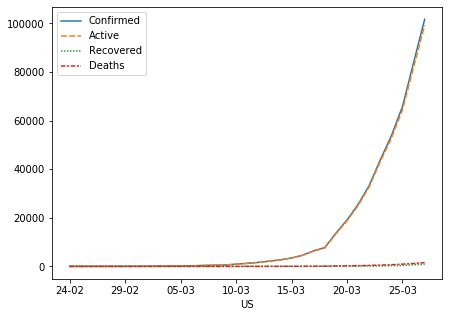


Daily growth for each types of cases



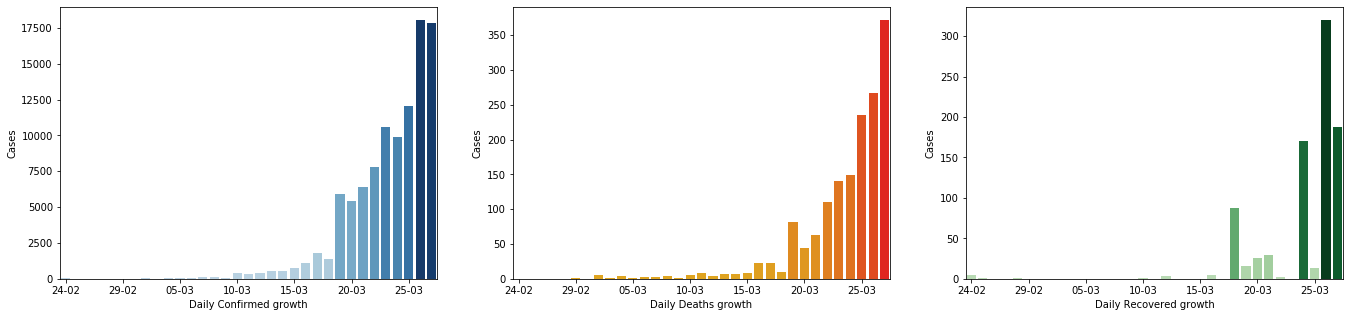

2 . Italy
Confirmed: 86498 
Active: 66414.0 
Recovered: 10950.0 
Deaths: 9134


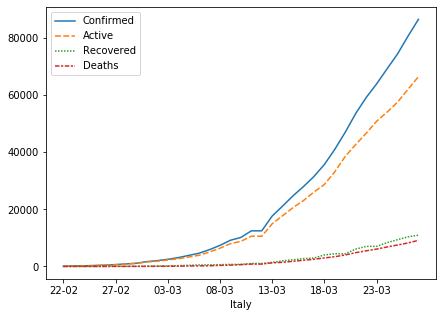


Daily growth for each types of cases



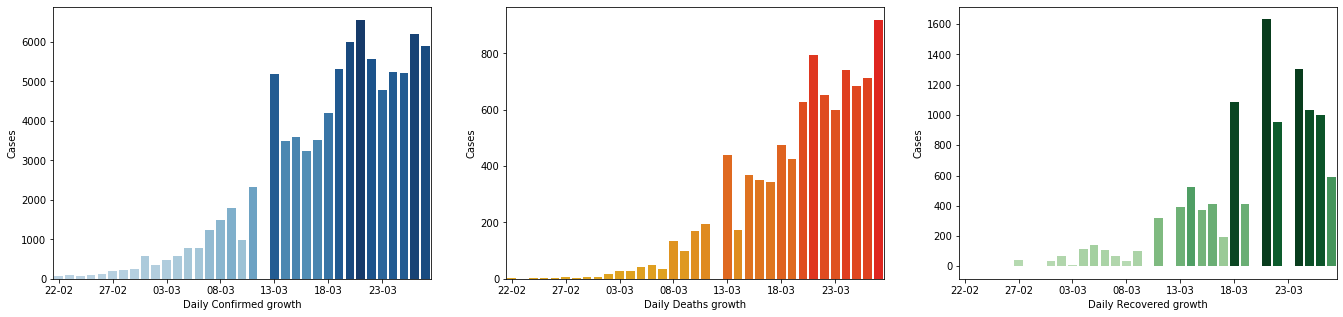

3 . China
Confirmed: 81897 
Active: 3881.0 
Recovered: 74720.0 
Deaths: 3296


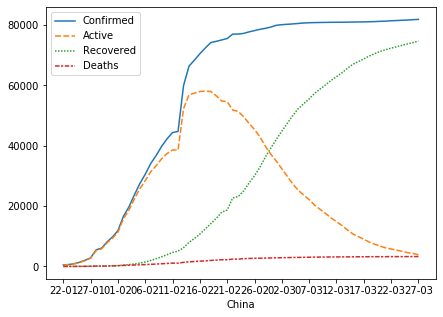


Daily growth for each types of cases



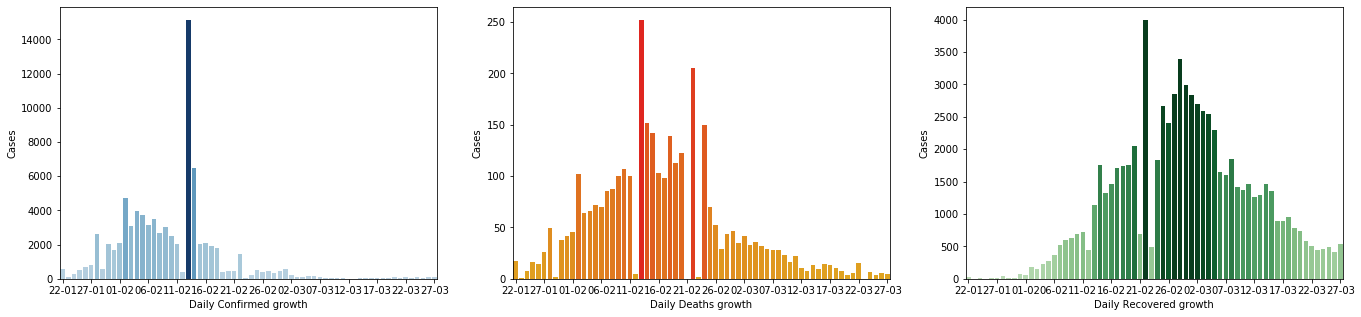

4 . Spain
Confirmed: 65719 
Active: 51224.0 
Recovered: 9357.0 
Deaths: 5138


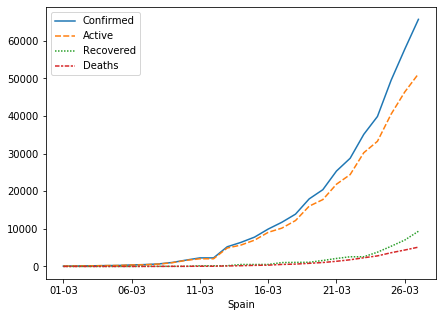


Daily growth for each types of cases



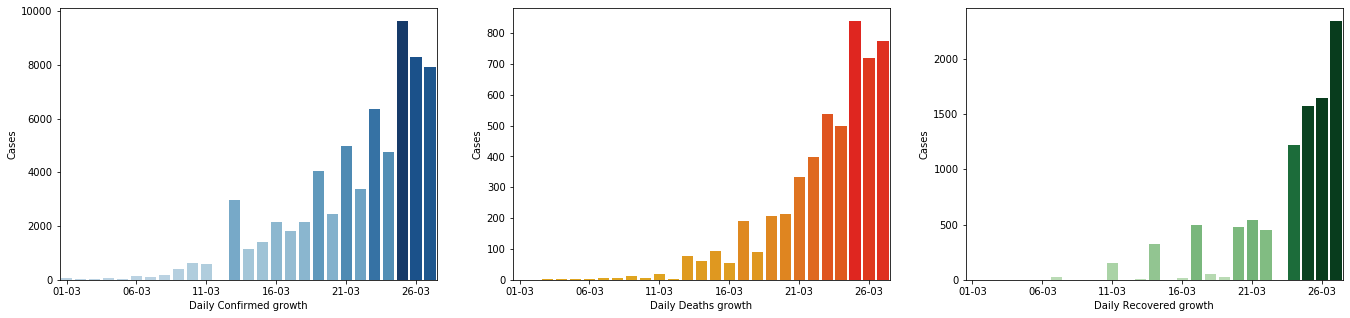

5 . Germany
Confirmed: 50871 
Active: 43871.0 
Recovered: 6658.0 
Deaths: 342


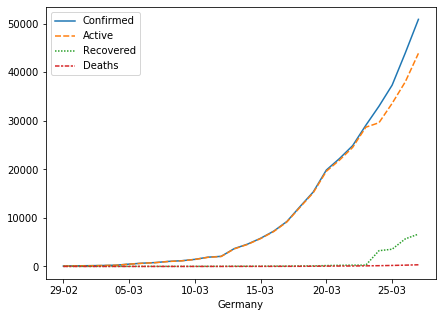


Daily growth for each types of cases



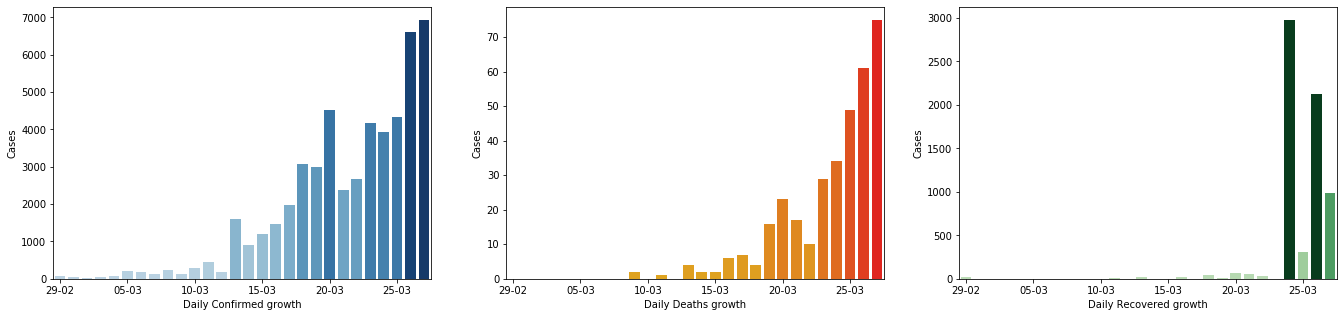

6 . France
Confirmed: 33402 
Active: 25698.0 
Recovered: 5707.0 
Deaths: 1997


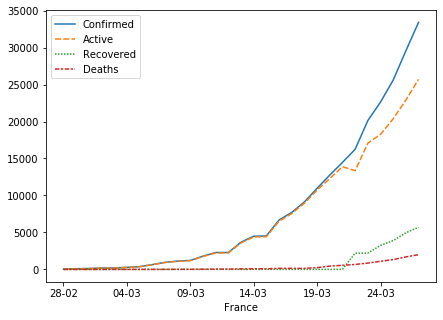


Daily growth for each types of cases



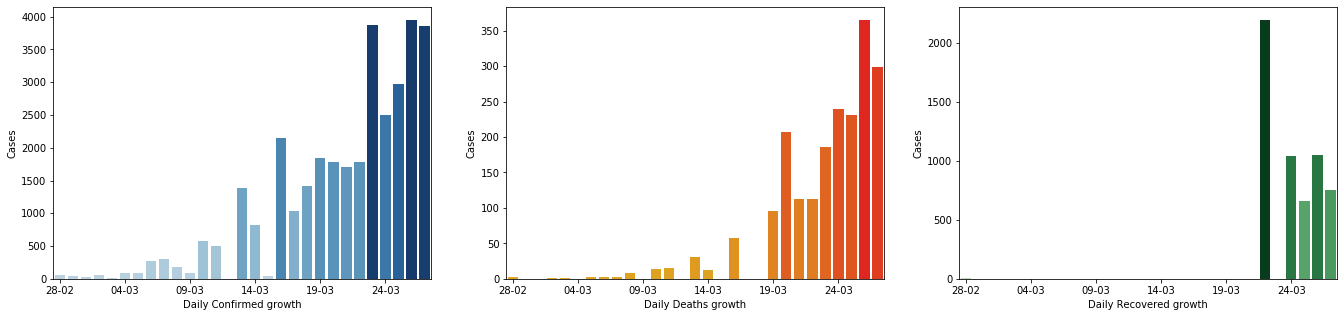

7 . Iran
Confirmed: 32332 
Active: 18821.0 
Recovered: 11133.0 
Deaths: 2378


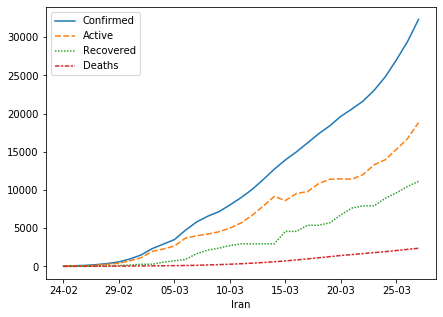


Daily growth for each types of cases



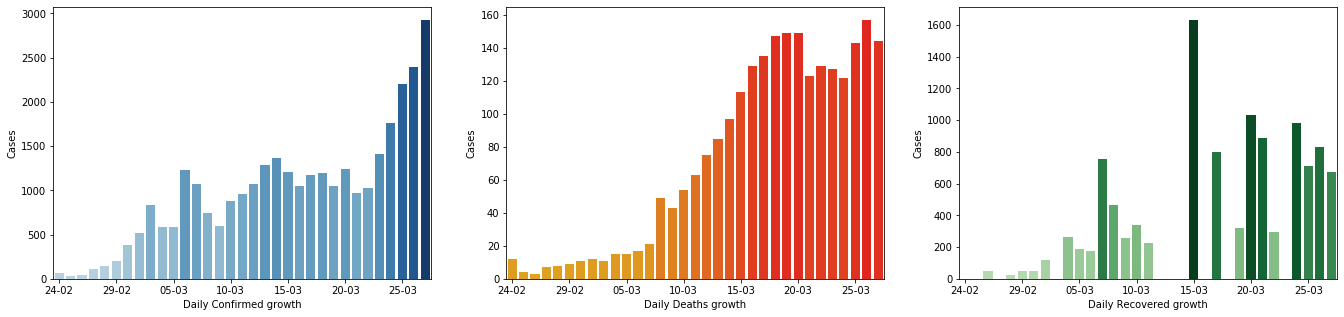

8 . United Kingdom
Confirmed: 14745 
Active: 13833.0 
Recovered: 151.0 
Deaths: 761


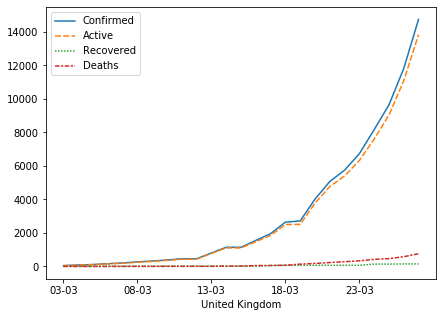


Daily growth for each types of cases



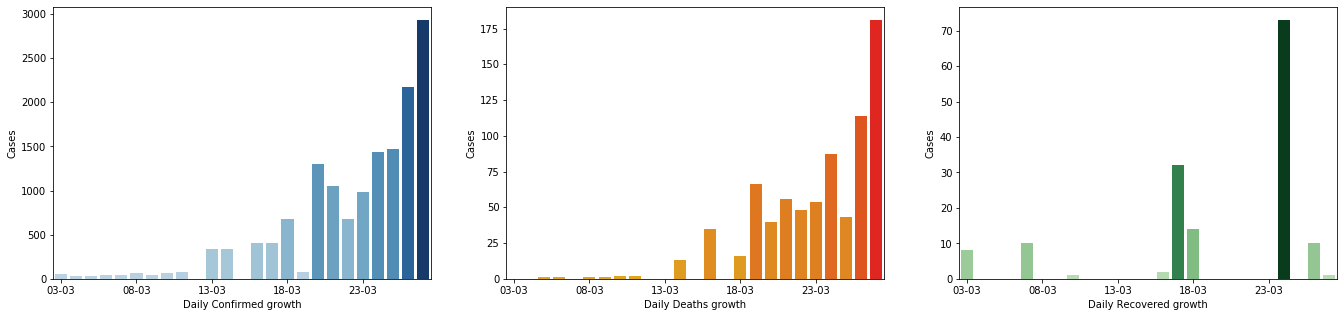

9 . Switzerland
Confirmed: 12928 
Active: 11167.0 
Recovered: 1530.0 
Deaths: 231


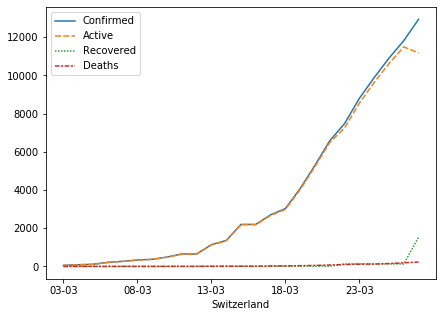


Daily growth for each types of cases



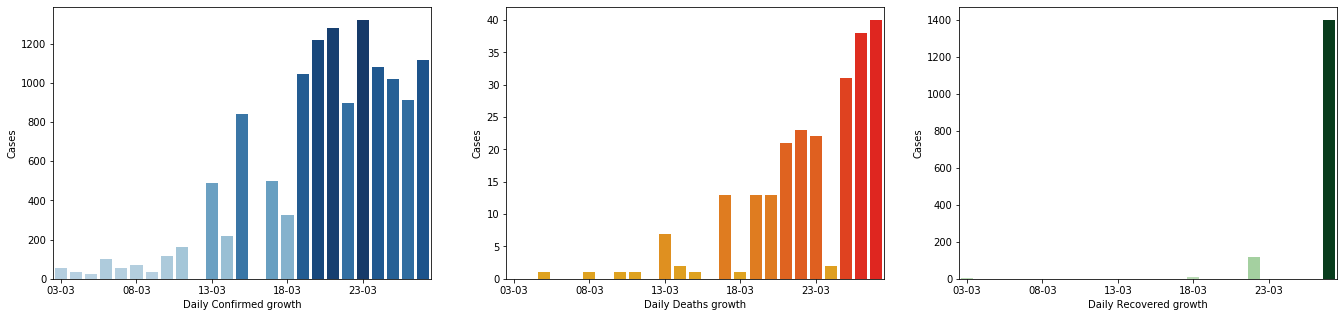

10 . Korea, South
Confirmed: 9332 
Active: 4665.0 
Recovered: 4528.0 
Deaths: 139


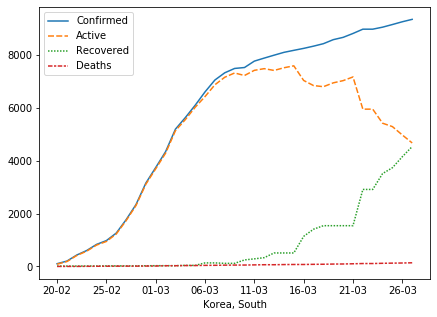


Daily growth for each types of cases



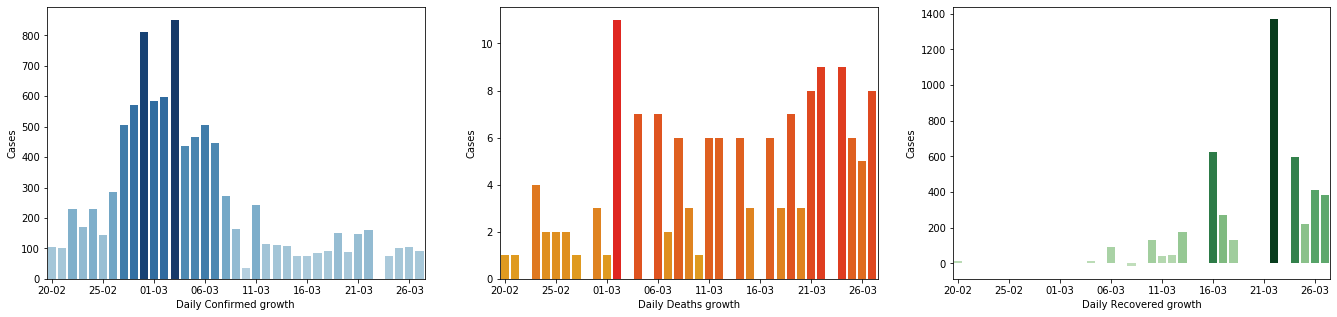

11 . Netherlands
Confirmed: 8647 
Active: 8094.0 
Recovered: 6.0 
Deaths: 547


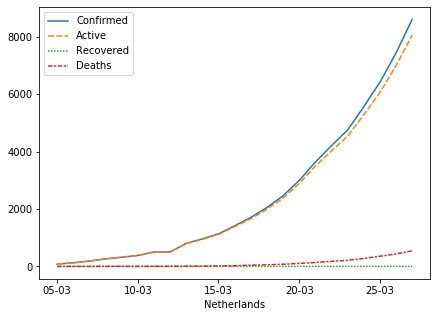


Daily growth for each types of cases



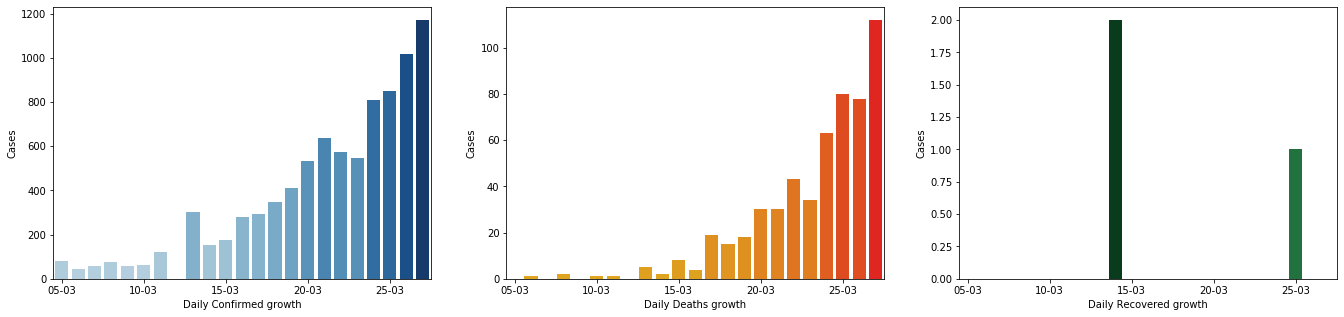

12 . Austria
Confirmed: 7657 
Active: 7374.0 
Recovered: 225.0 
Deaths: 58


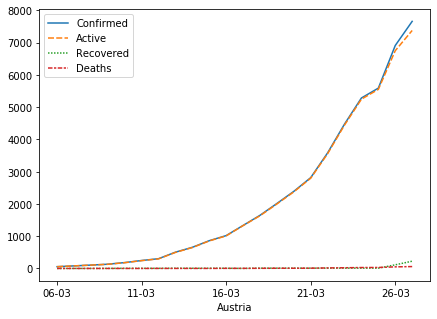


Daily growth for each types of cases



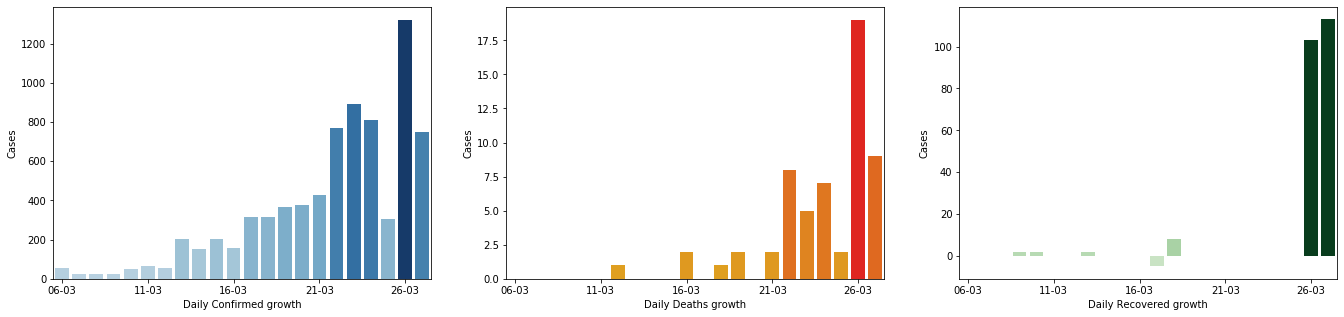

13 . Belgium
Confirmed: 7284 
Active: 6137.0 
Recovered: 858.0 
Deaths: 289


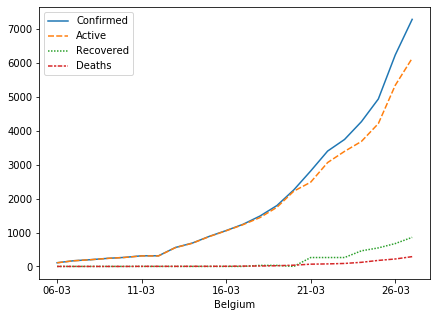


Daily growth for each types of cases



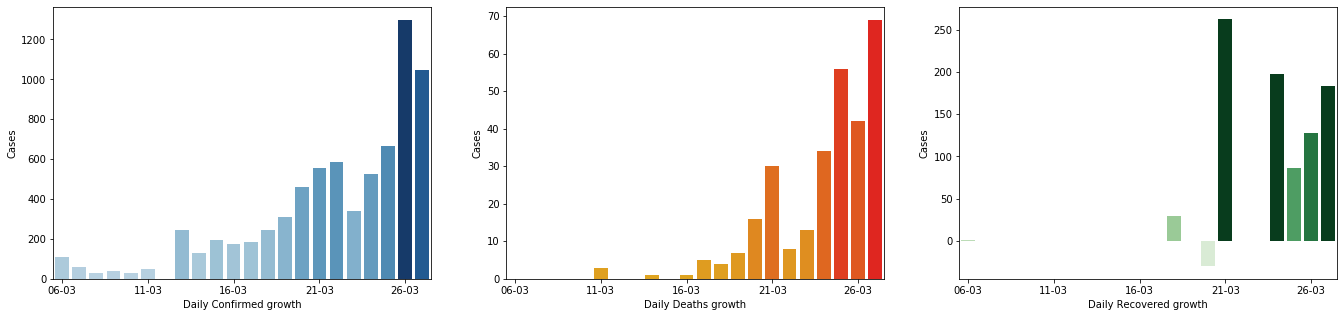

14 . Turkey
Confirmed: 5698 
Active: 5564.0 
Recovered: 42.0 
Deaths: 92


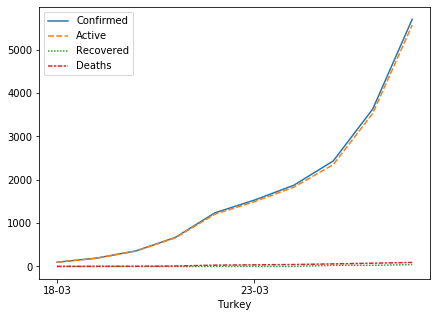


Daily growth for each types of cases



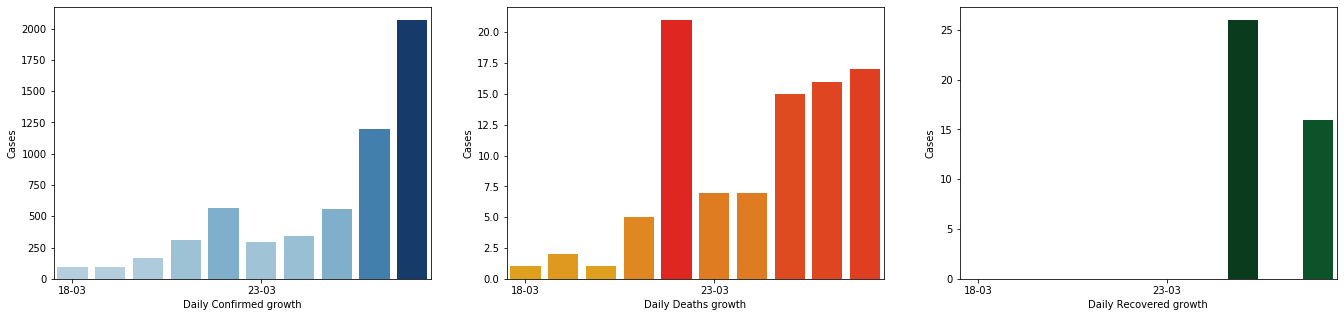

15 . Canada
Confirmed: 4682 
Active: 0.0 
Recovered: 0.0 
Deaths: 54


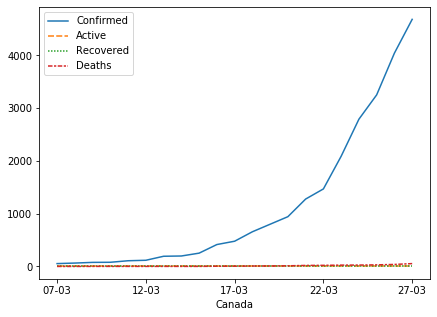


Daily growth for each types of cases



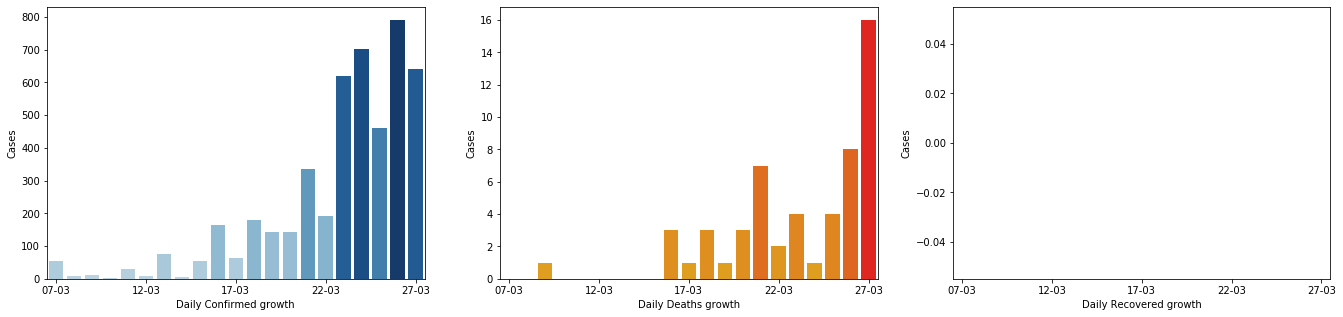

16 . Portugal
Confirmed: 4268 
Active: 4149.0 
Recovered: 43.0 
Deaths: 76


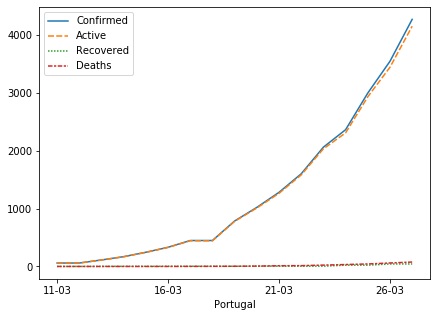


Daily growth for each types of cases



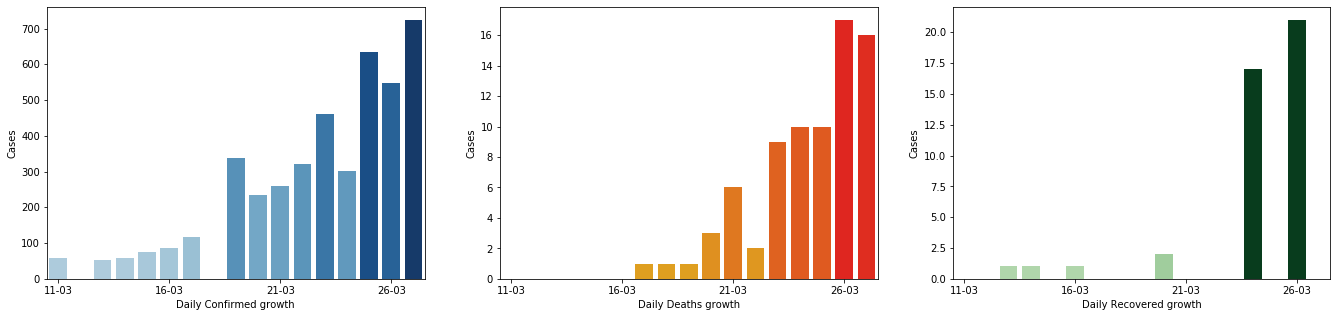

17 . Norway
Confirmed: 3755 
Active: 3730.0 
Recovered: 6.0 
Deaths: 19


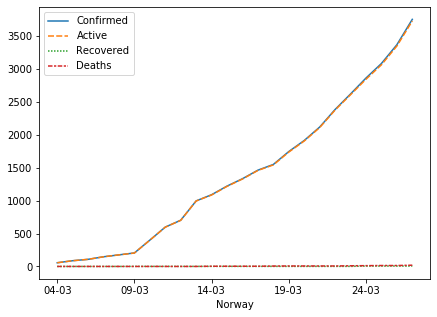


Daily growth for each types of cases



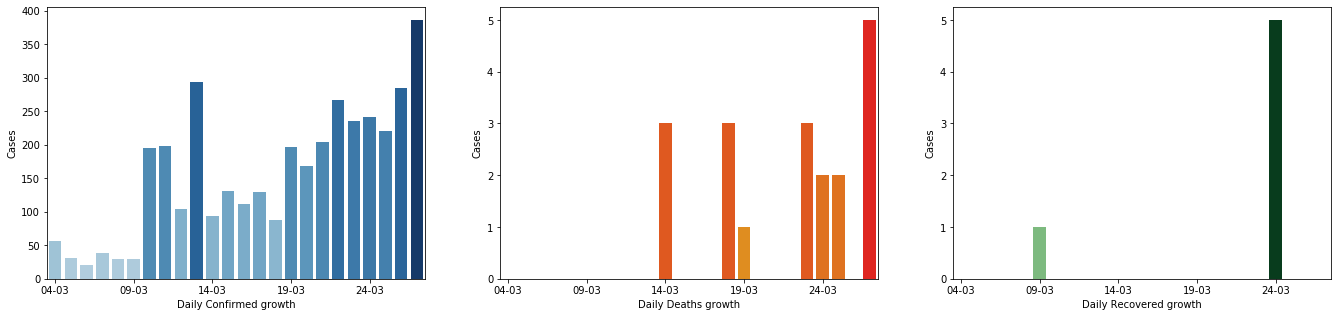

18 . Brazil
Confirmed: 3417 
Active: 3319.0 
Recovered: 6.0 
Deaths: 92


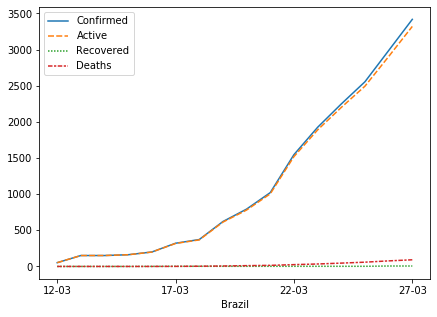


Daily growth for each types of cases



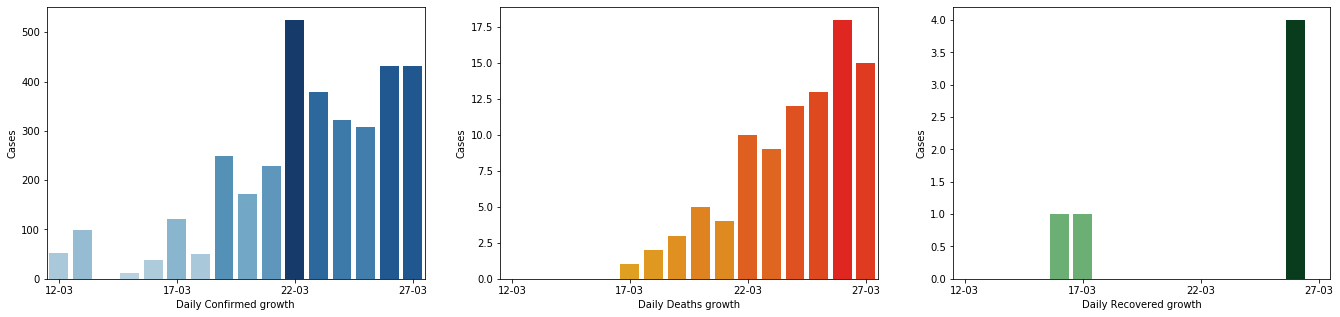

19 . Australia
Confirmed: 3143 
Active: 2936.0 
Recovered: 194.0 
Deaths: 13


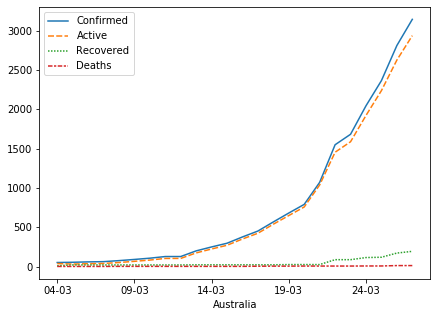


Daily growth for each types of cases



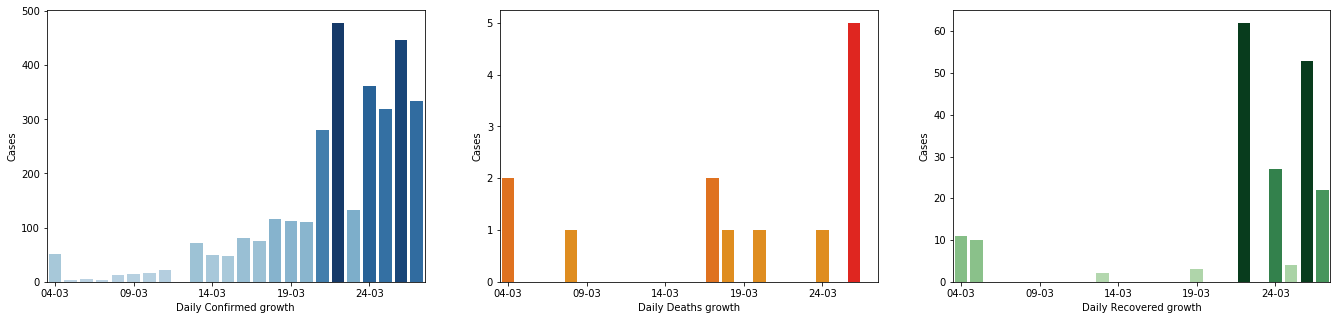

20 . Sweden
Confirmed: 3069 
Active: 2948.0 
Recovered: 16.0 
Deaths: 105


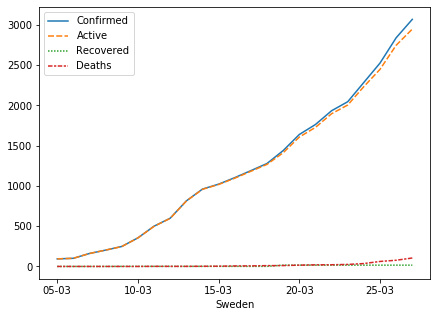


Daily growth for each types of cases



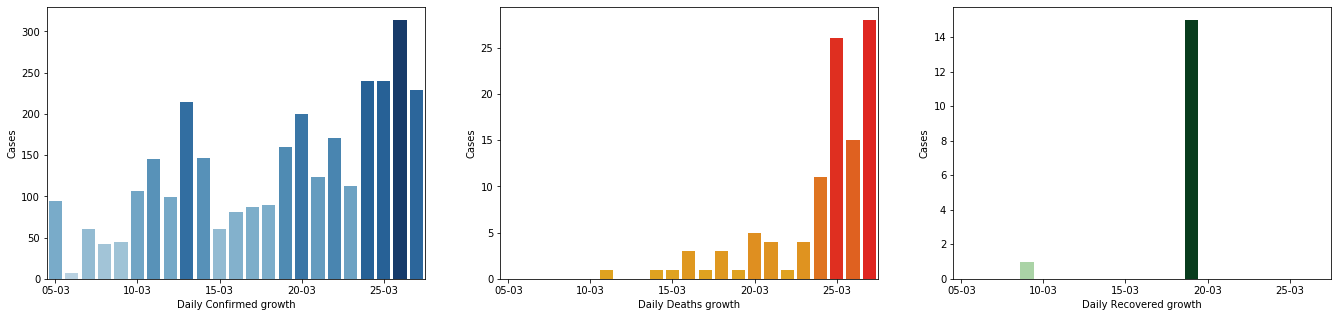

21 . Israel
Confirmed: 3035 
Active: 2944.0 
Recovered: 79.0 
Deaths: 12


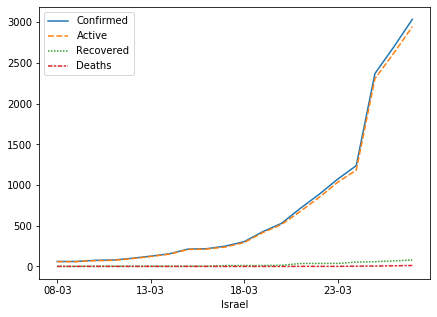


Daily growth for each types of cases



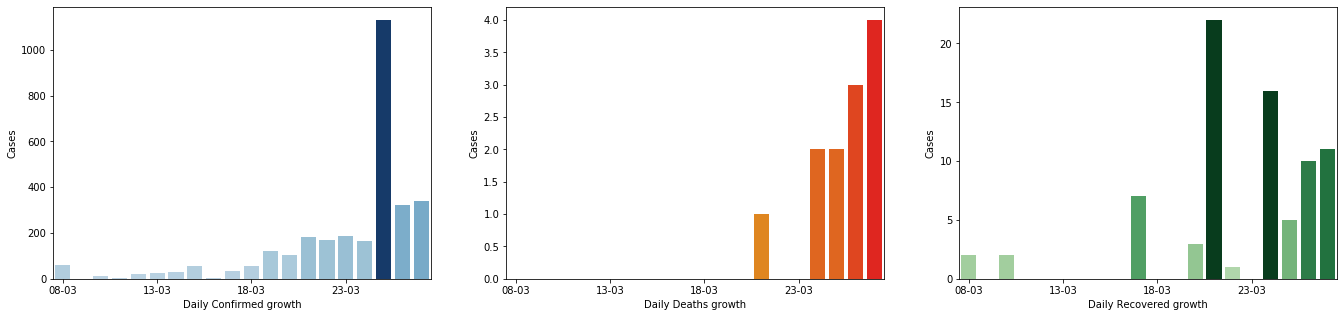

22 . Czechia
Confirmed: 2279 
Active: 2259.0 
Recovered: 11.0 
Deaths: 9


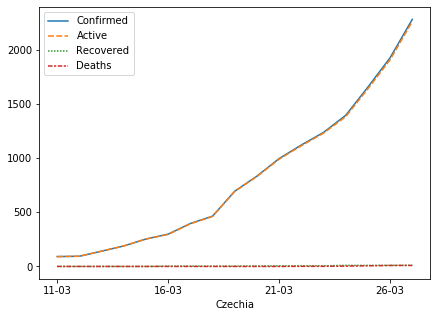


Daily growth for each types of cases



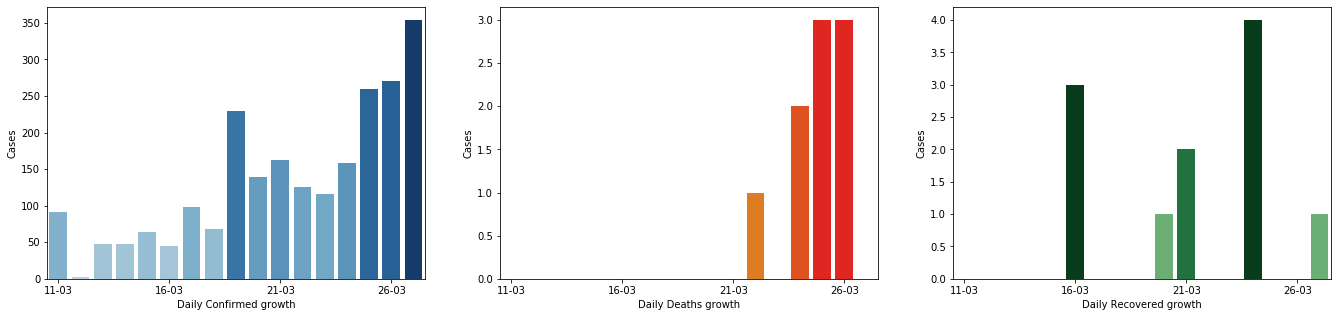

23 . Denmark
Confirmed: 2200 
Active: 2091.0 
Recovered: 57.0 
Deaths: 52


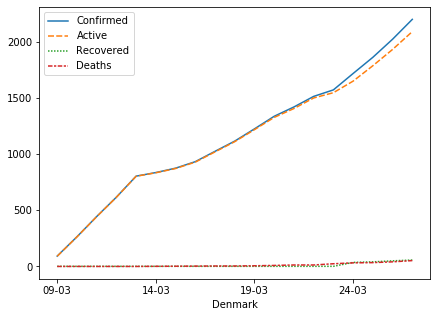


Daily growth for each types of cases



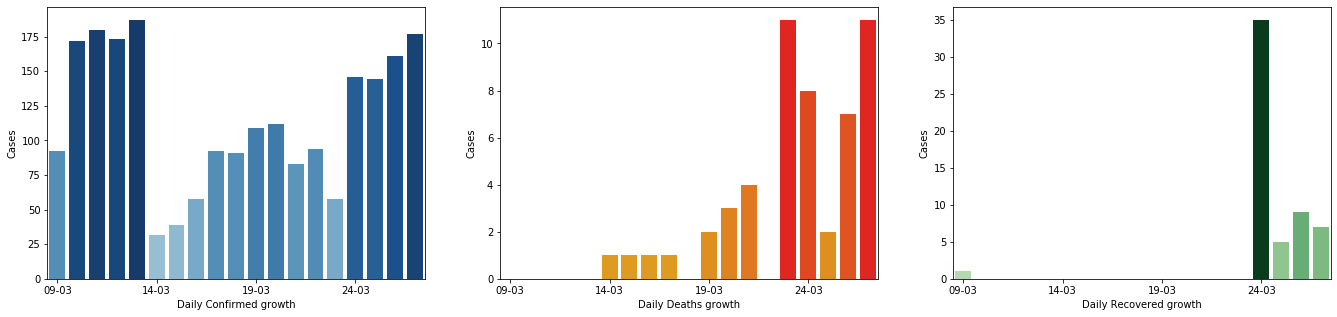

24 . Malaysia
Confirmed: 2161 
Active: 1876.0 
Recovered: 259.0 
Deaths: 26


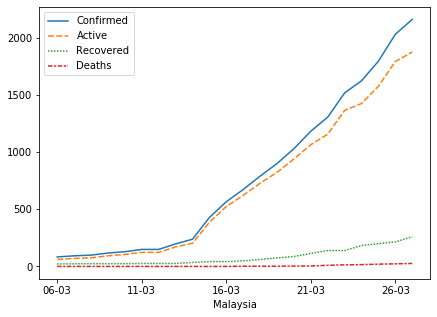


Daily growth for each types of cases



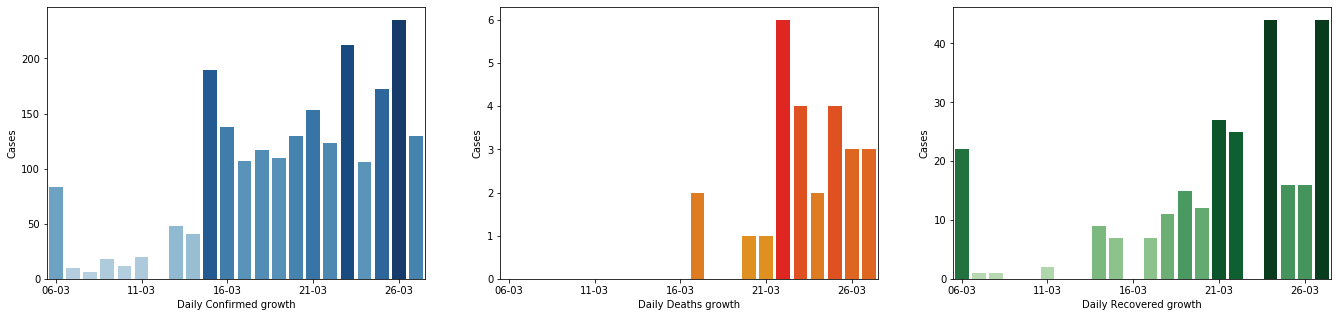

25 . Ireland
Confirmed: 2121 
Active: 2094.0 
Recovered: 5.0 
Deaths: 22


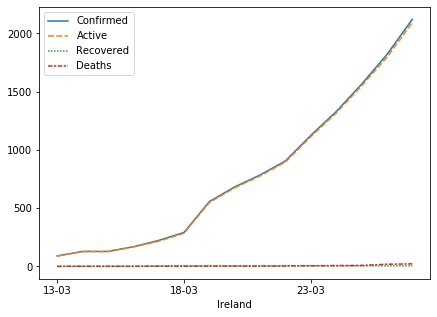


Daily growth for each types of cases



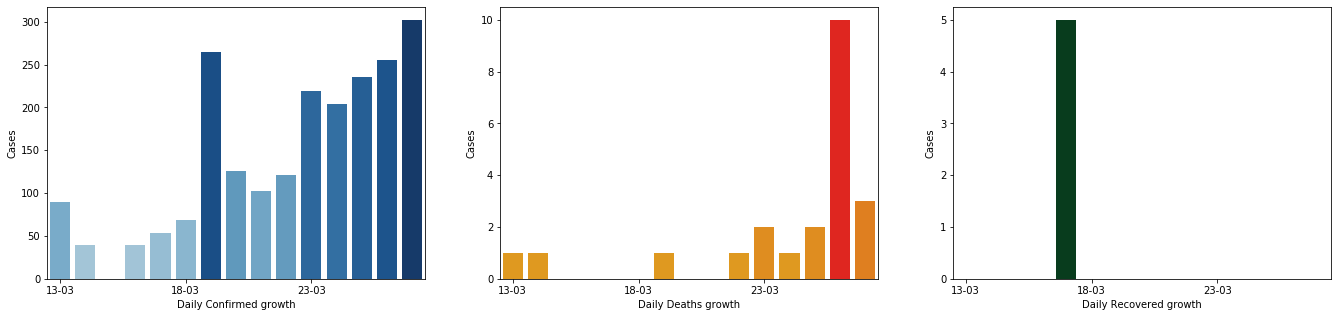

26 . Chile
Confirmed: 1610 
Active: 1562.0 
Recovered: 43.0 
Deaths: 5


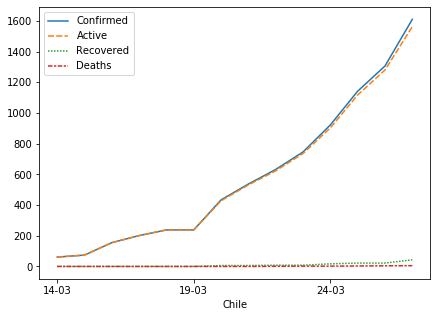


Daily growth for each types of cases



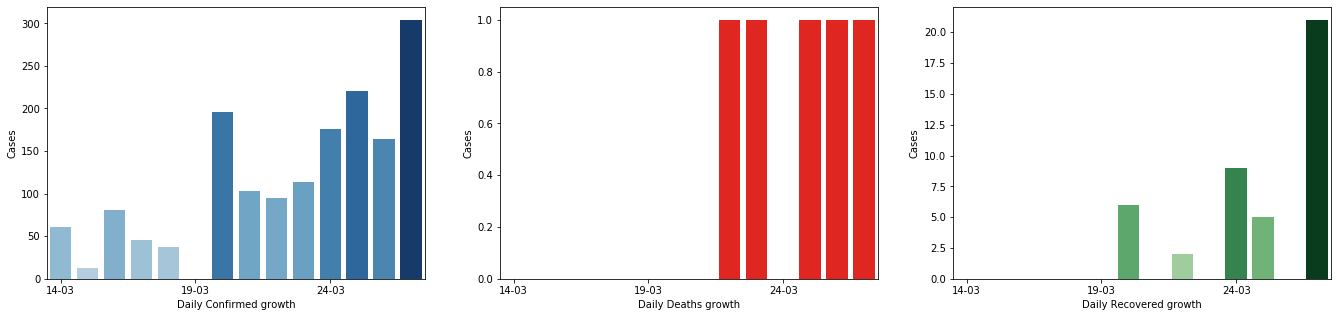

27 . Luxembourg
Confirmed: 1605 
Active: 1550.0 
Recovered: 40.0 
Deaths: 15


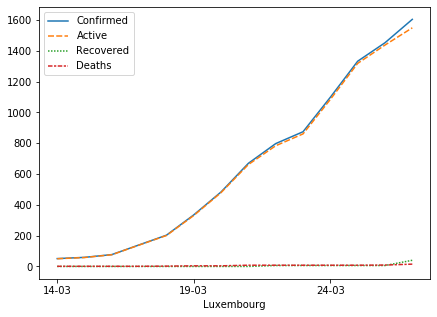


Daily growth for each types of cases



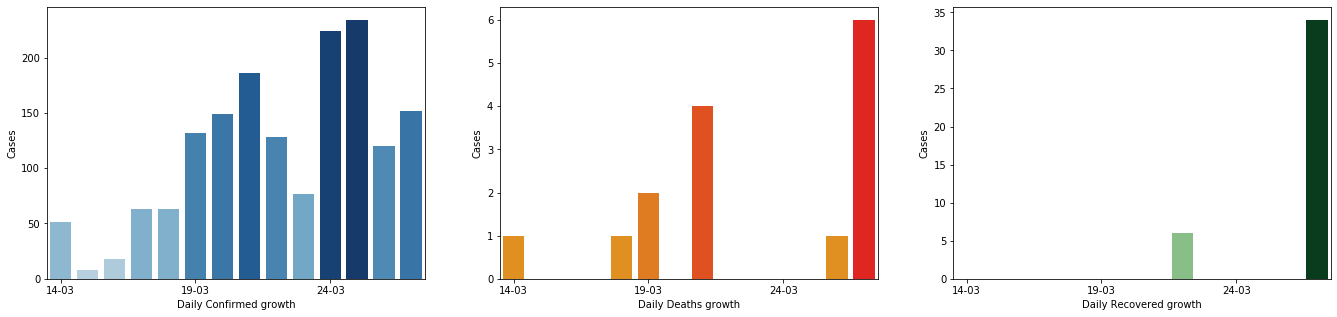

28 . Ecuador
Confirmed: 1595 
Active: 1556.0 
Recovered: 3.0 
Deaths: 36


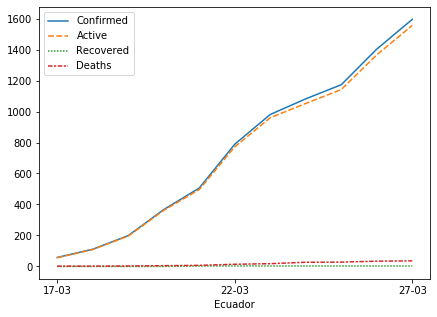


Daily growth for each types of cases



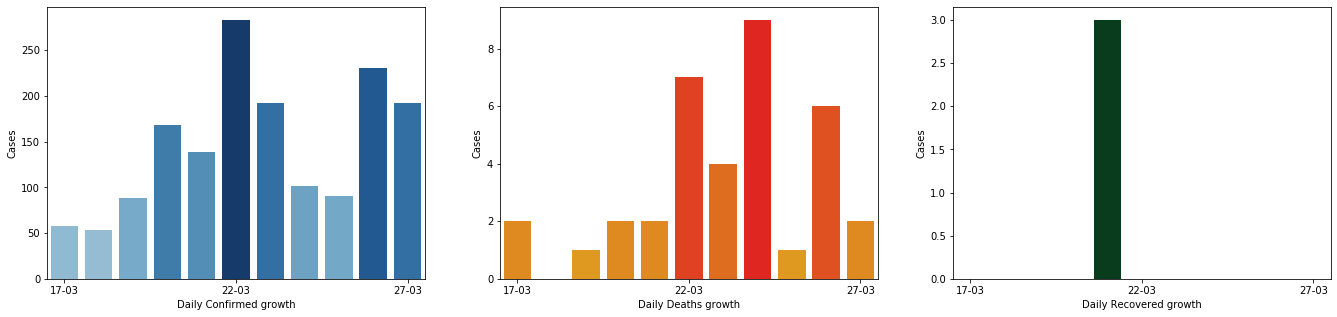

29 . Japan
Confirmed: 1468 
Active: 1047.0 
Recovered: 372.0 
Deaths: 49


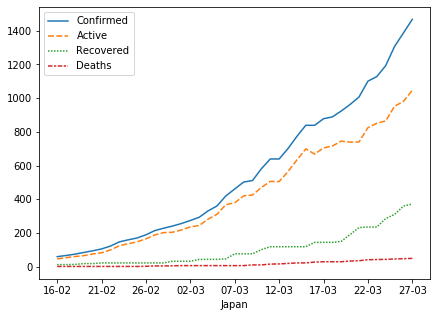


Daily growth for each types of cases



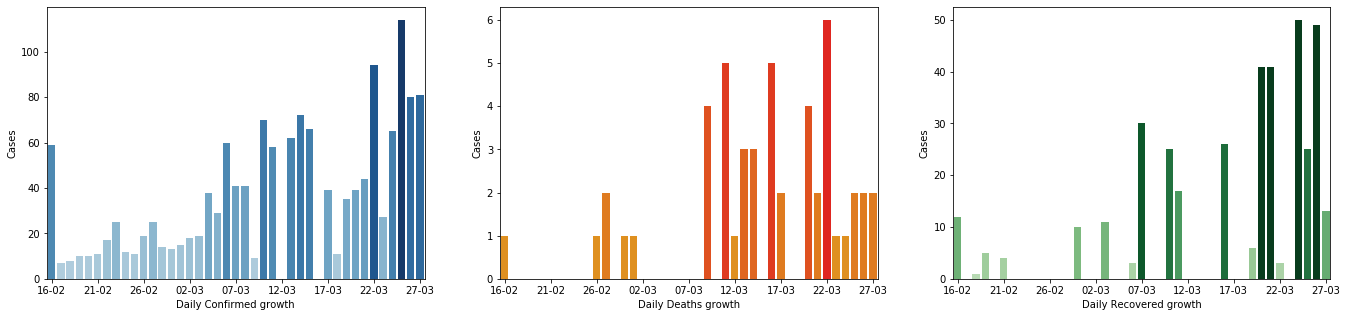

30 . Poland
Confirmed: 1389 
Active: 1366.0 
Recovered: 7.0 
Deaths: 16


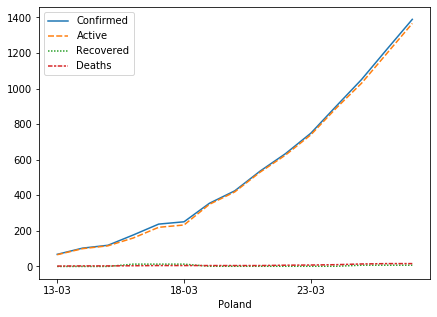


Daily growth for each types of cases



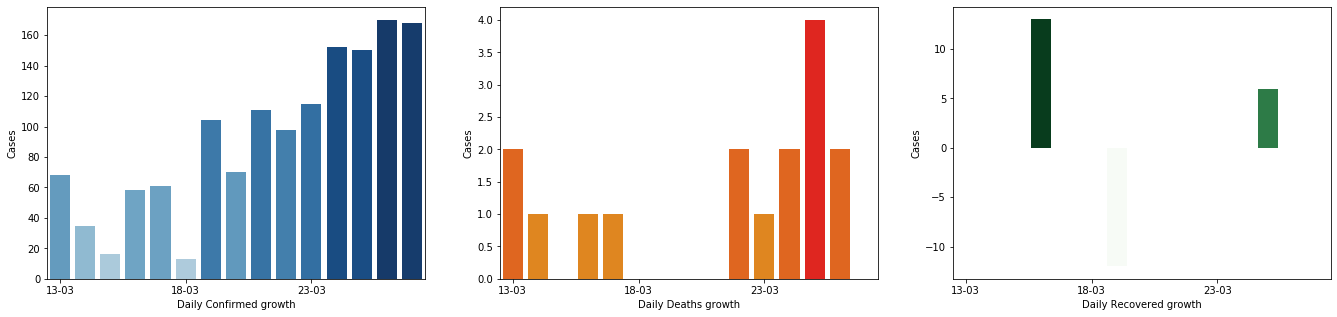

31 . Pakistan
Confirmed: 1373 
Active: 1339.0 
Recovered: 23.0 
Deaths: 11


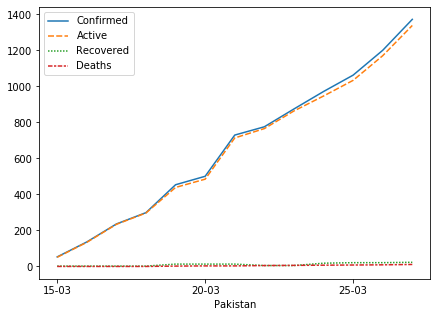


Daily growth for each types of cases



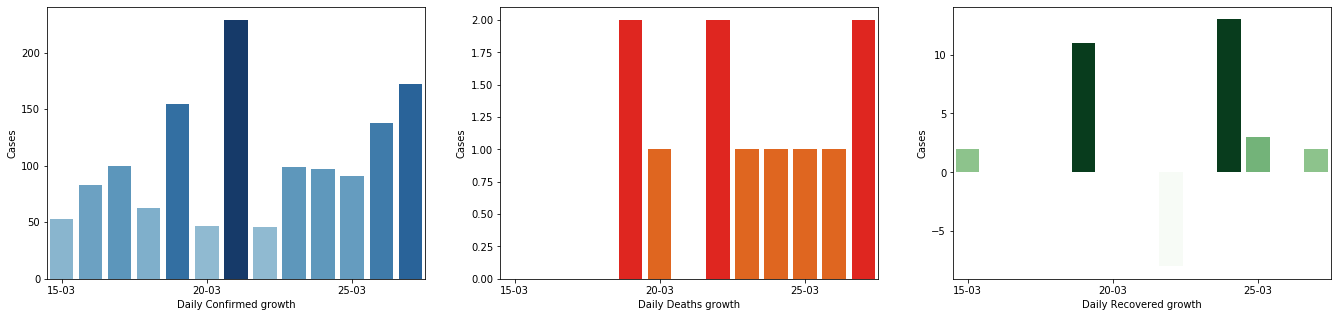

32 . Romania
Confirmed: 1292 
Active: 1151.0 
Recovered: 115.0 
Deaths: 26


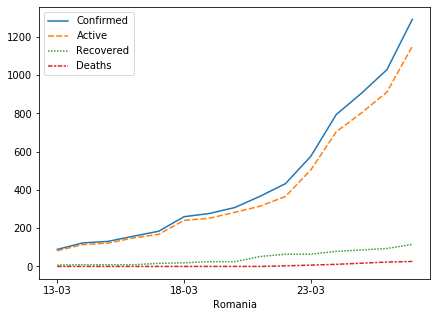


Daily growth for each types of cases



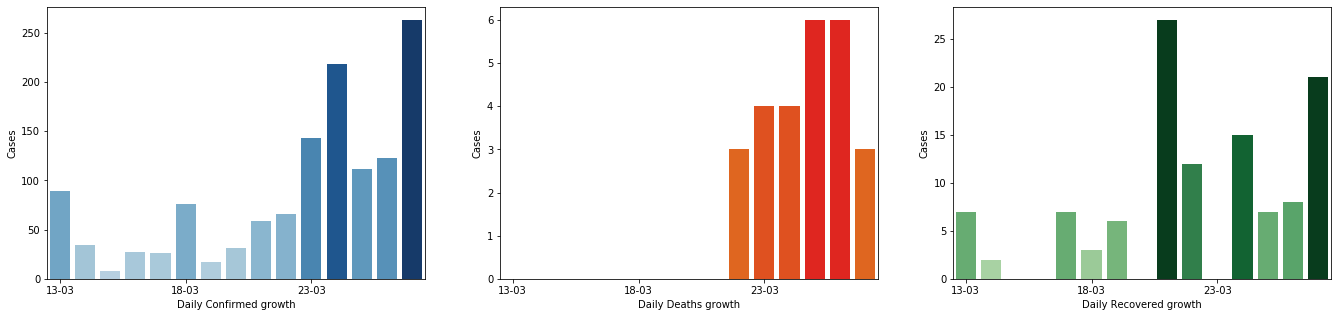

33 . South Africa
Confirmed: 1170 
Active: 1138.0 
Recovered: 31.0 
Deaths: 1


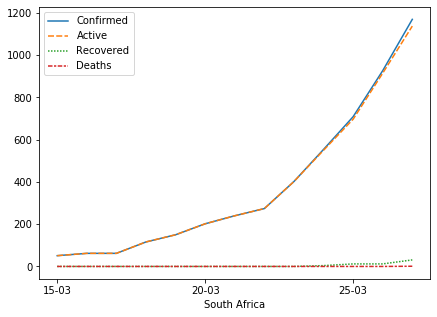


Daily growth for each types of cases



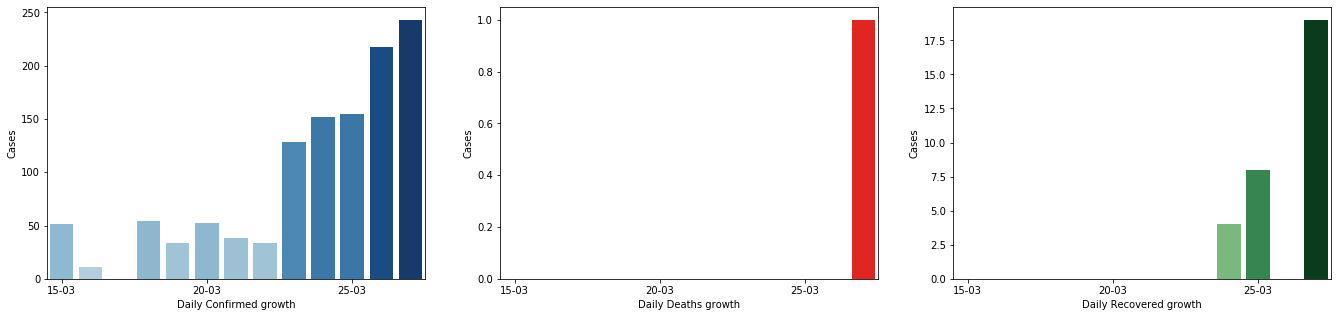

34 . Thailand
Confirmed: 1136 
Active: 1034.0 
Recovered: 97.0 
Deaths: 5


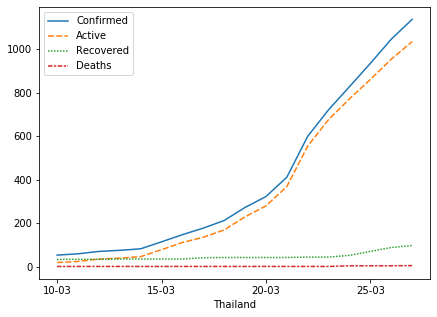


Daily growth for each types of cases



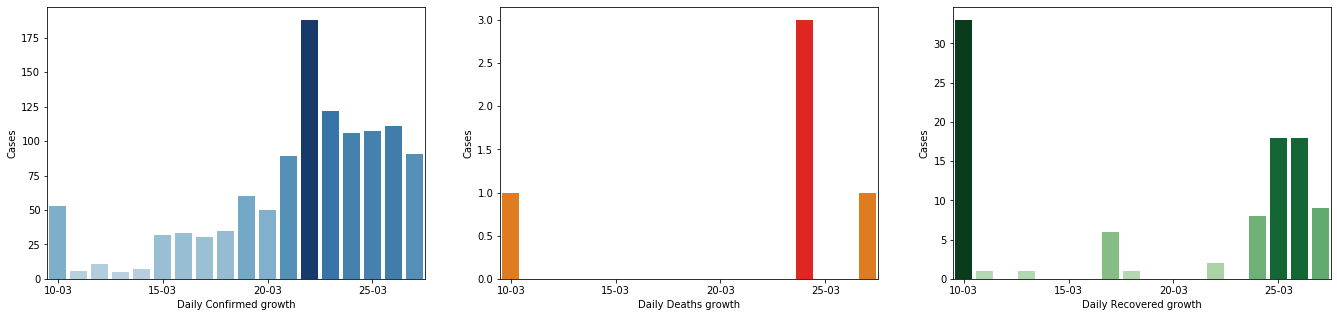

35 . Saudi Arabia
Confirmed: 1104 
Active: 1066.0 
Recovered: 35.0 
Deaths: 3


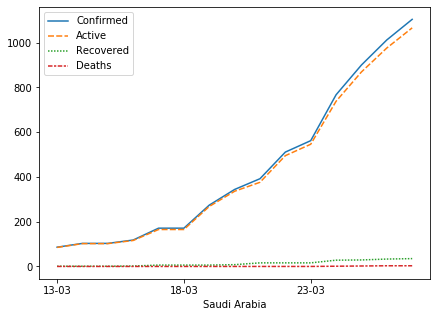


Daily growth for each types of cases



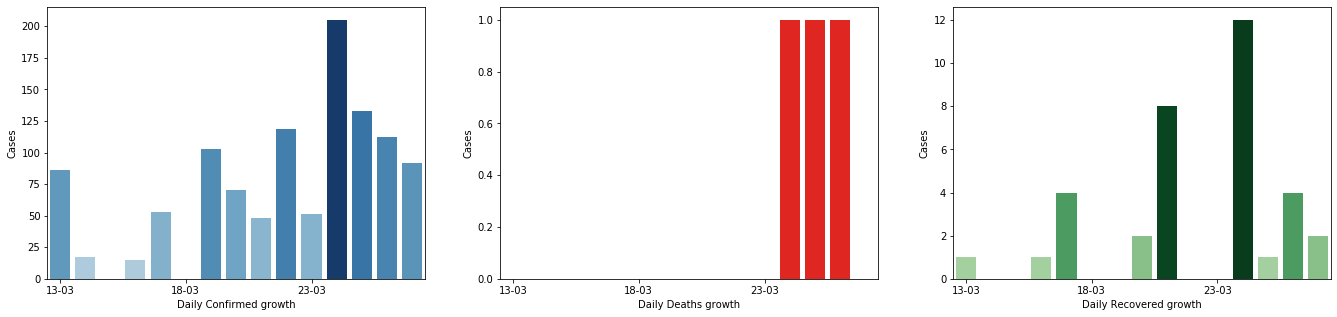

36 . Indonesia
Confirmed: 1046 
Active: 913.0 
Recovered: 46.0 
Deaths: 87


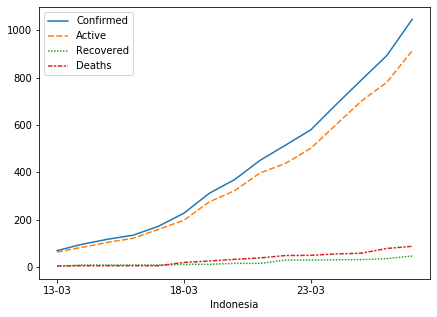


Daily growth for each types of cases



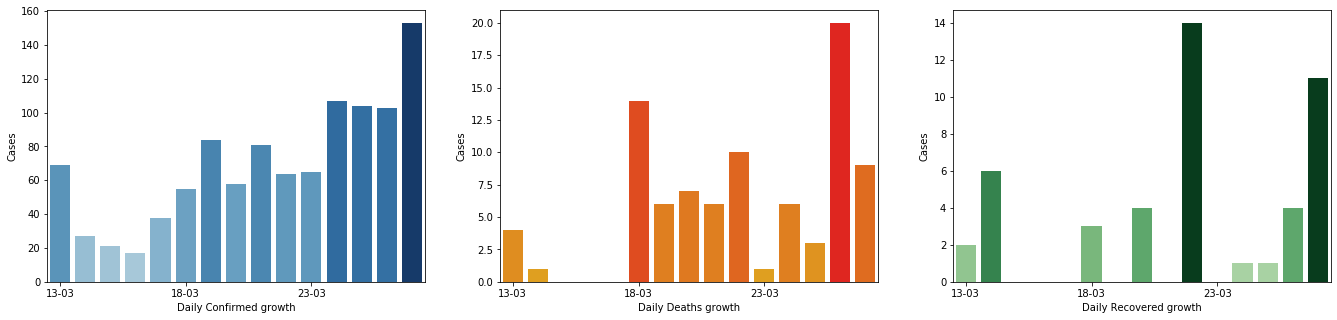

37 . Finland
Confirmed: 1041 
Active: 1024.0 
Recovered: 10.0 
Deaths: 7


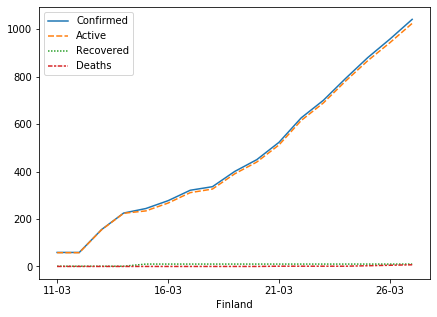


Daily growth for each types of cases



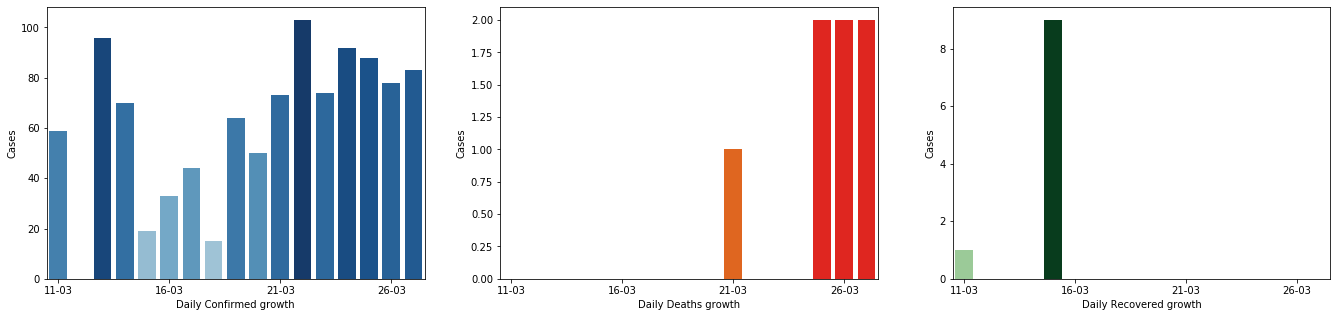

38 . Russia
Confirmed: 1036 
Active: 987.0 
Recovered: 45.0 
Deaths: 4


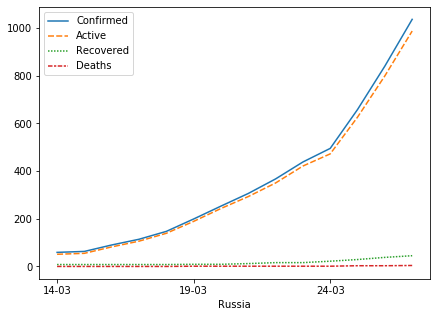


Daily growth for each types of cases



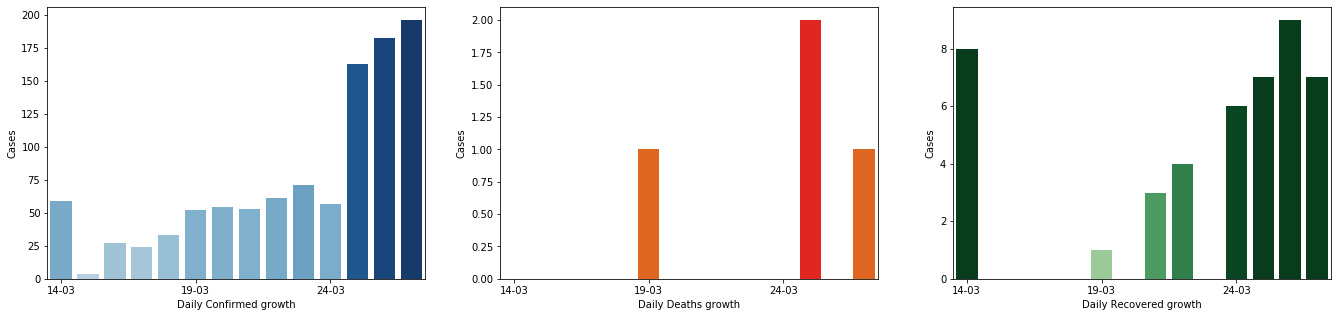

39 . Greece
Confirmed: 966 
Active: 886.0 
Recovered: 52.0 
Deaths: 28


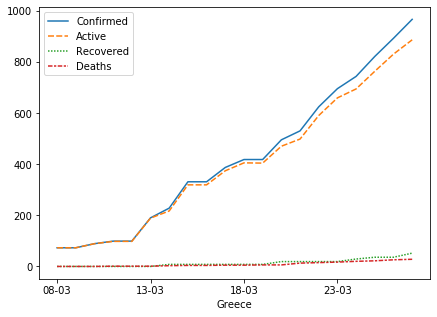


Daily growth for each types of cases



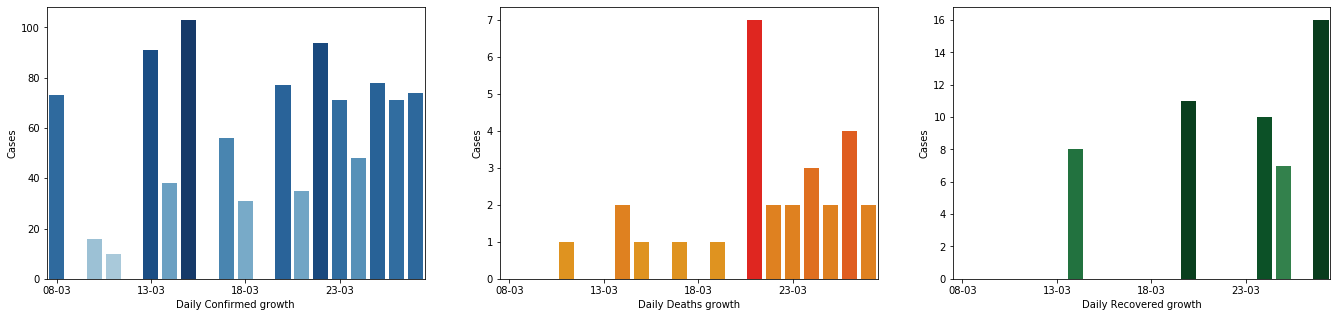

40 . Iceland
Confirmed: 890 
Active: 791.0 
Recovered: 97.0 
Deaths: 2


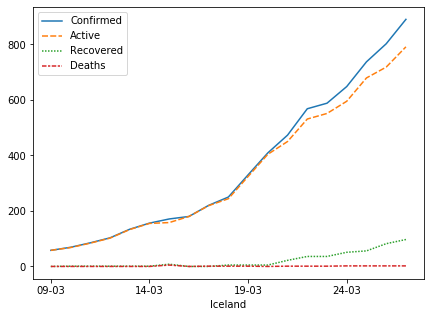


Daily growth for each types of cases



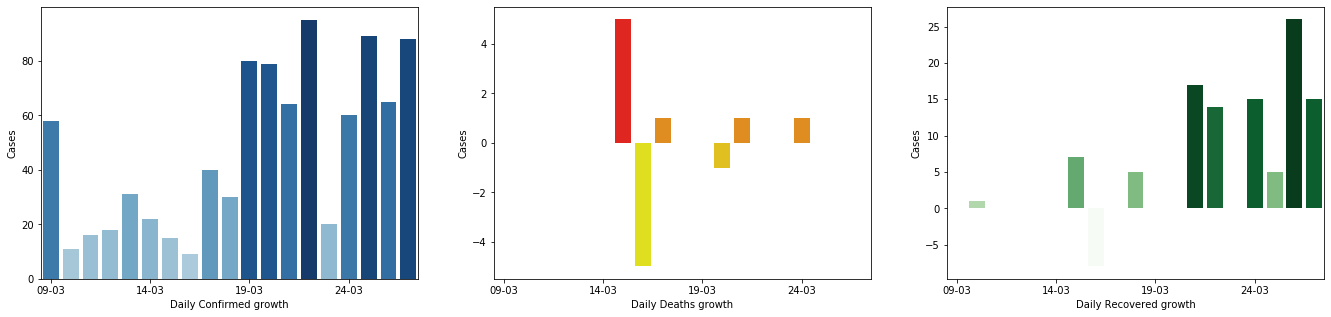

41 . India
Confirmed: 887 
Active: 794.0 
Recovered: 73.0 
Deaths: 20


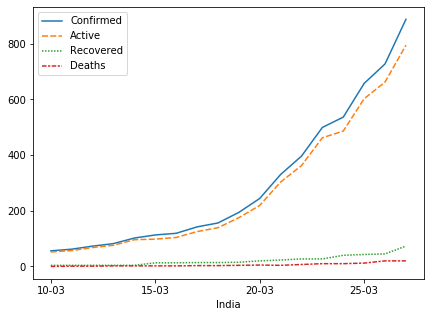


Daily growth for each types of cases



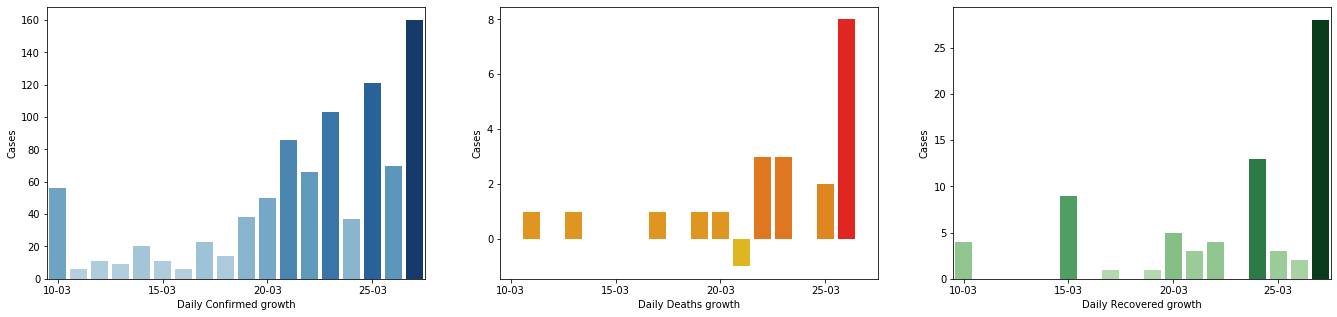

42 . Philippines
Confirmed: 803 
Active: 718.0 
Recovered: 31.0 
Deaths: 54


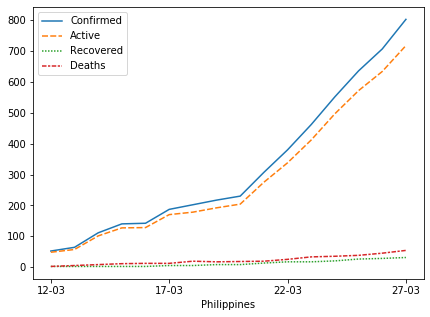


Daily growth for each types of cases



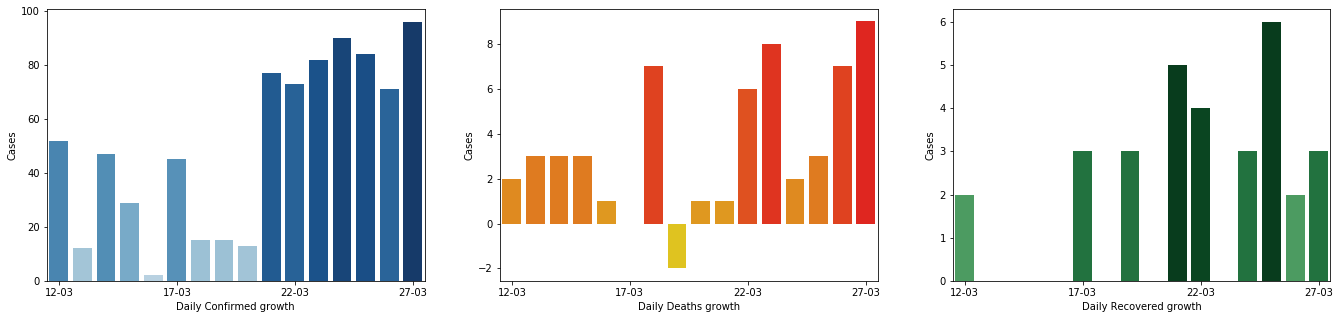

43 . Singapore
Confirmed: 732 
Active: 547.0 
Recovered: 183.0 
Deaths: 2


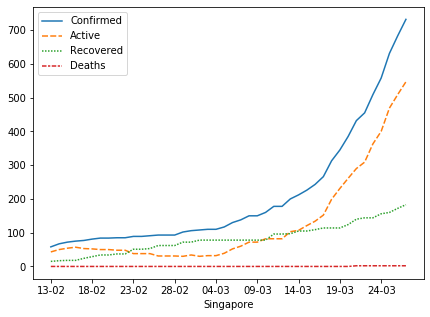


Daily growth for each types of cases



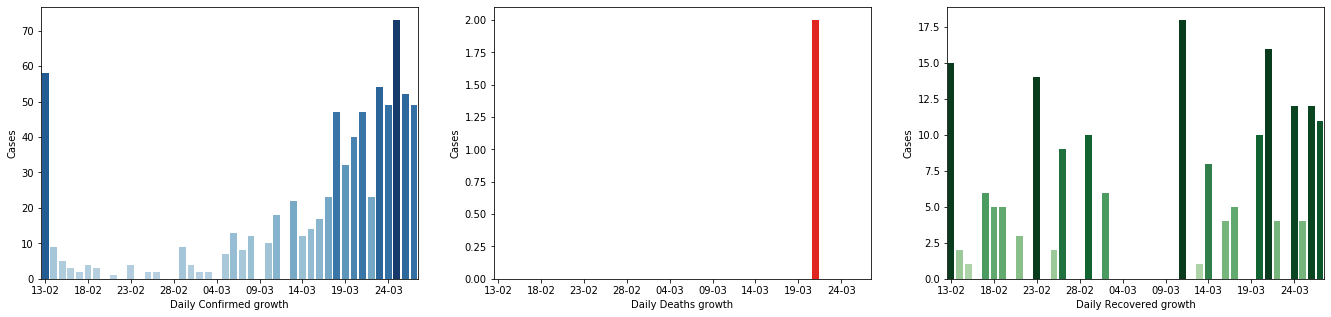

44 . Diamond Princess
Confirmed: 712 
Active: 105.0 
Recovered: 597.0 
Deaths: 10


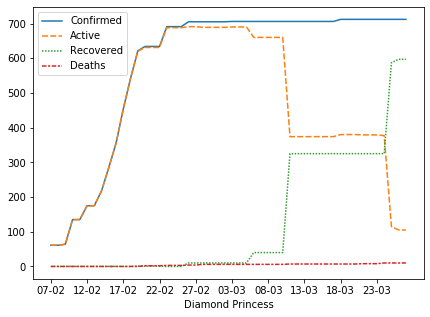


Daily growth for each types of cases



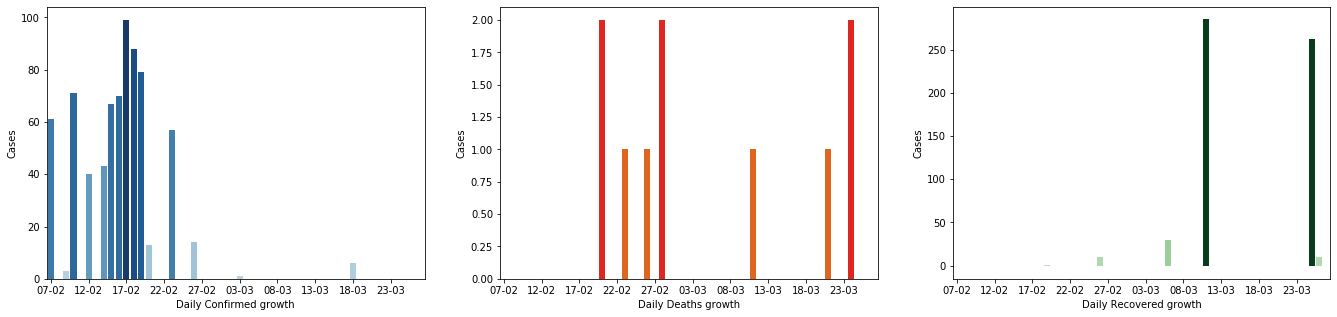

45 . Panama
Confirmed: 674 
Active: 663.0 
Recovered: 2.0 
Deaths: 9


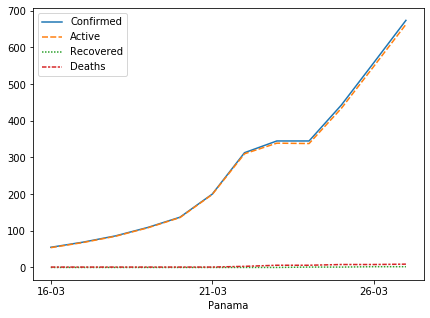


Daily growth for each types of cases



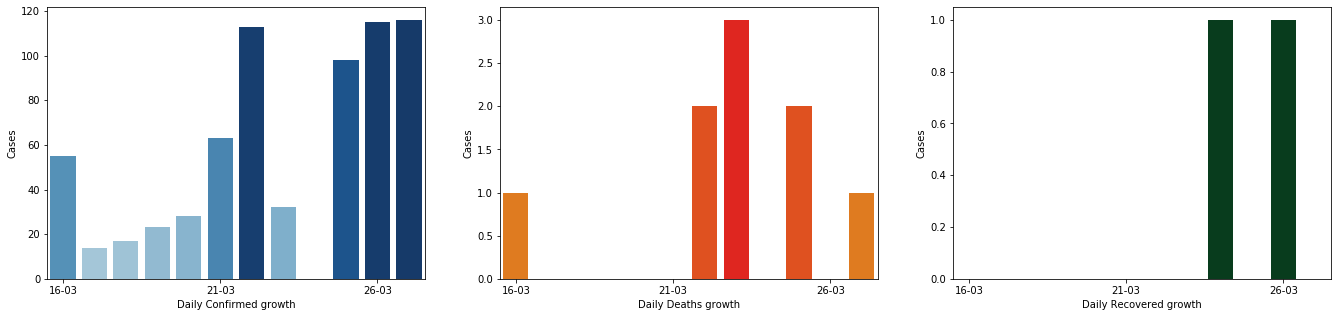

46 . Peru
Confirmed: 635 
Active: 608.0 
Recovered: 16.0 
Deaths: 11


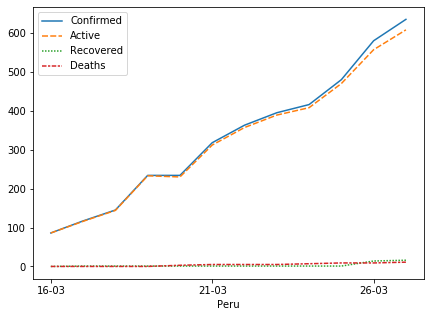


Daily growth for each types of cases



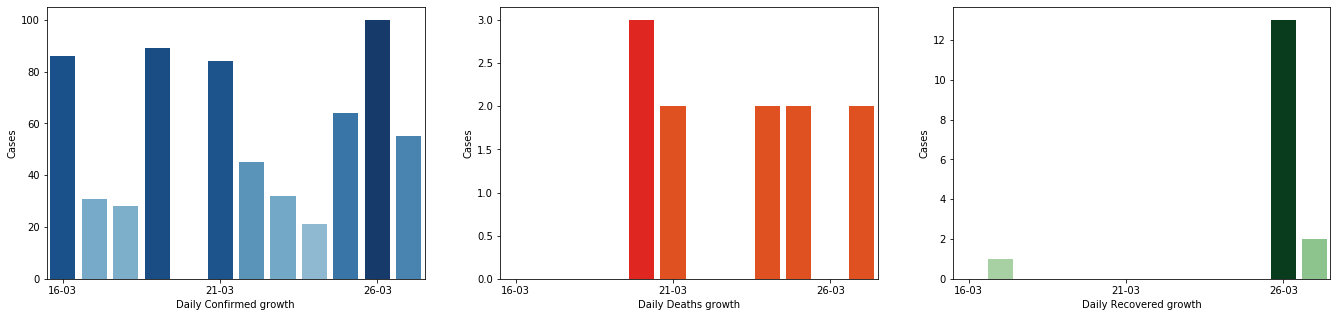

47 . Slovenia
Confirmed: 632 
Active: 613.0 
Recovered: 10.0 
Deaths: 9


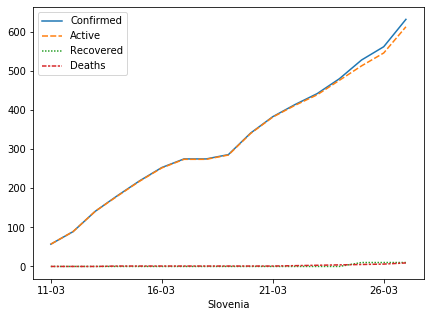


Daily growth for each types of cases



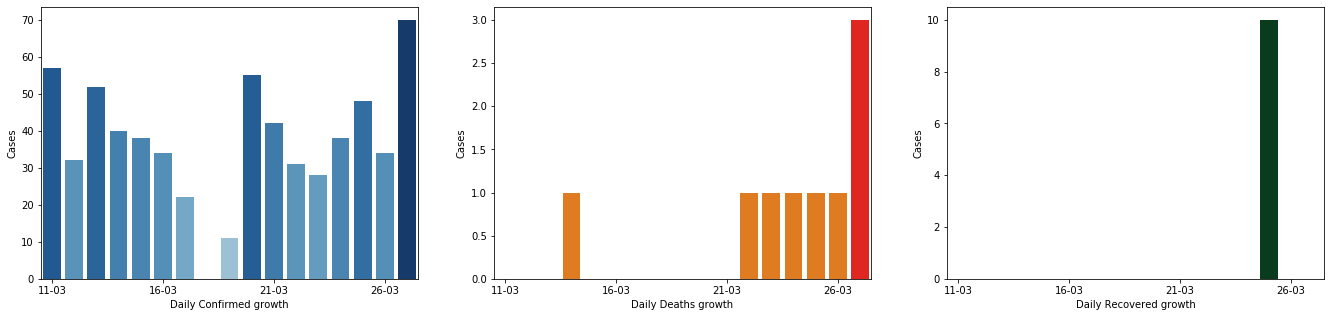

48 . Argentina
Confirmed: 589 
Active: 504.0 
Recovered: 72.0 
Deaths: 13


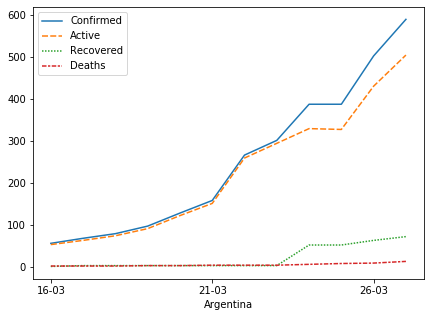


Daily growth for each types of cases



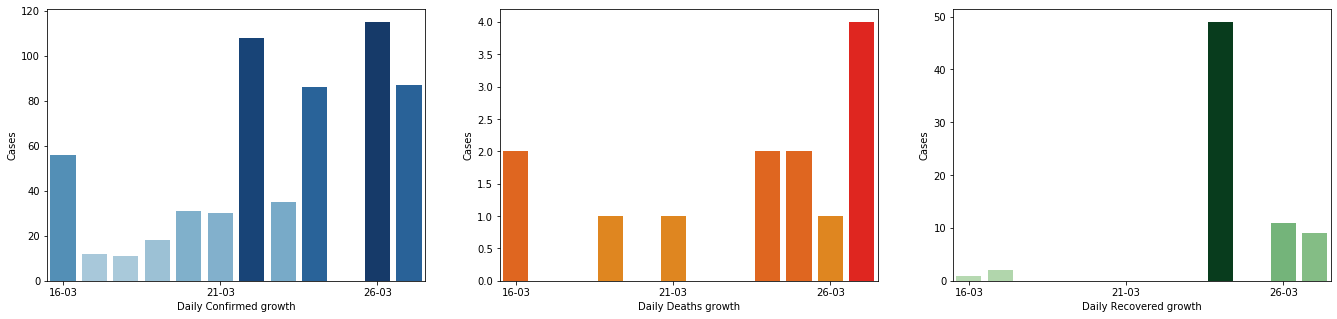

49 . Croatia
Confirmed: 586 
Active: 546.0 
Recovered: 37.0 
Deaths: 3


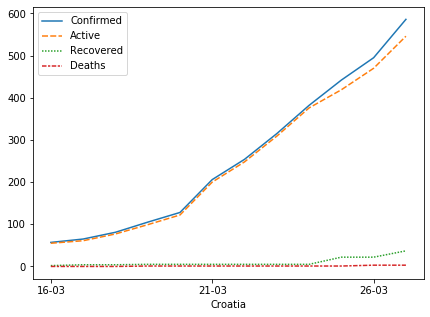


Daily growth for each types of cases



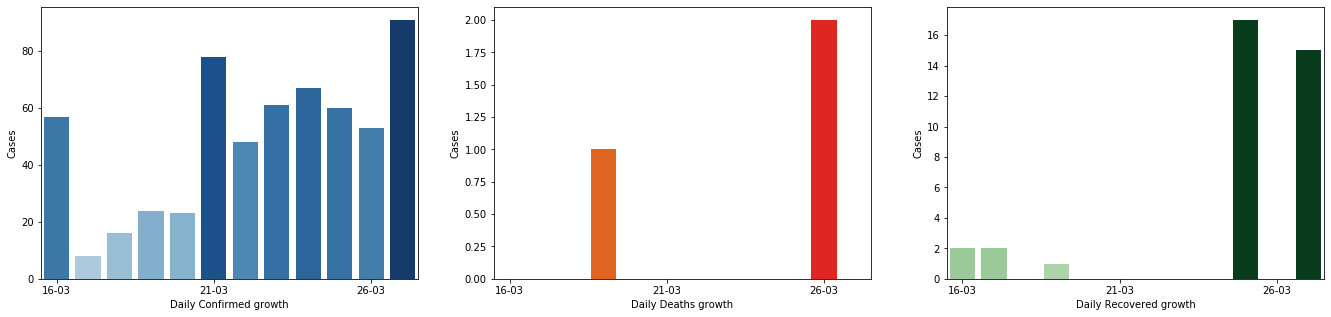

50 . Mexico
Confirmed: 585 
Active: 573.0 
Recovered: 4.0 
Deaths: 8


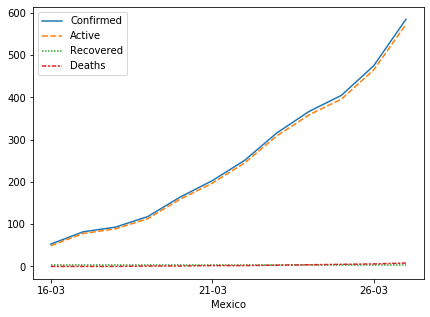


Daily growth for each types of cases



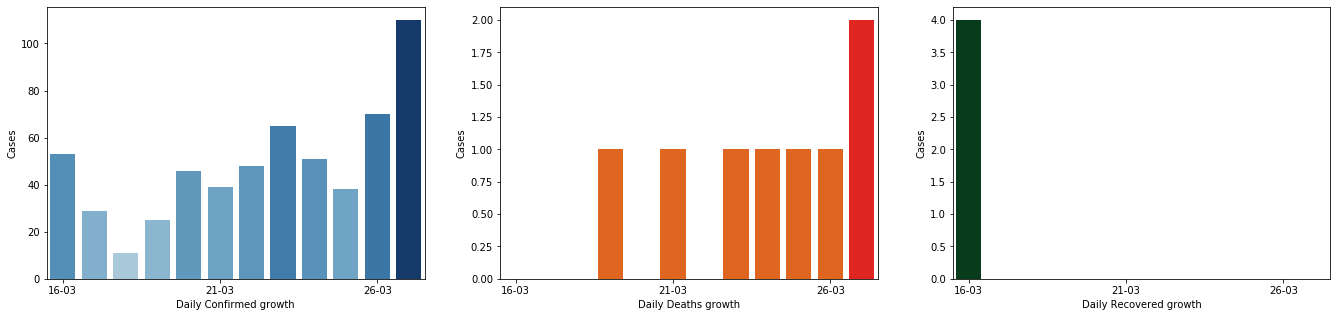

In [15]:
for index, country in enumerate(top_50.index):
    print(index+1,'.', country)
    print('Confirmed:', top_50.Confirmed[country],'\n'\
          'Active:', top_50.Active[country],'\n'\
          'Recovered:', top_50.Recovered[country],'\n'\
          'Deaths:', top_50.Deaths[country]
         )
    df, date_range = prepare_data(covid_19_df, country, 50)
    df = add_data(df)
    show_increment(df, country, date_range)